# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


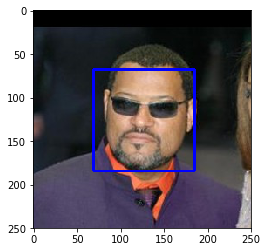

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 99% of the images in 'human_files' have a detected human face and 11 % of the images in 'dog_files' have a detected human face.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_files_detected = 0
for file in human_files_short:
    if face_detector(file):
        human_files_detected += 1

dog_files_detected = 0
for file in dog_files_short:
    if face_detector(file):
        dog_files_detected += 1

print("human detected in human files: ", human_files_detected, "%")
print("human detected in dog files: ", dog_files_detected, "%")

human detected in human files:  99 %
human detected in dog files:  11 %


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ Yes, I think it's a reasonable expectation but it would be better if it scored 100% in detecting humans in human files. If someone provides a human image and the model fails to detect a human, that someone can get very frustrated. In order to solve this, I guess drawing a ROC curve and trying to adjust the model to have as high true positive(detect humans in human images) score as possible seems to be the way.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

In [7]:
# make dataset consist of 50% humans and 50% dogs

dog_size = len(train_files)

# randomly choose dog_size humans
random_humans = np.random.choice(human_files, size=dog_size, replace=False)

# add target data (human = 1)
random_humans = np.hstack((random_humans.reshape(-1,1), np.ones(random_humans.shape).reshape(-1,1)))
random_humans.shape

(6680, 2)

In [8]:
# 50% dogs
dogs = np.hstack((train_files.reshape(-1,1), np.zeros(train_files.shape).reshape(-1,1)))
dogs.shape

(6680, 2)

In [9]:
# full dataset
option_dataset = np.vstack((random_humans, dogs))
option_dataset.shape

(13360, 2)

In [10]:
# shuffle and split into train/testset
np.random.shuffle(option_dataset)
split_size = int(len(option_dataset) * 0.8)
option_train = option_dataset[:split_size]
option_test = option_dataset[split_size:]

print("trainset size: ", len(option_train))
print("trainset humans: ", sum(option_train[:,1].astype("float")))
print("testset size: ", len(option_test))
print("testset humans: ", sum(option_test[:,1].astype("float")))

trainset size:  10688
trainset humans:  5383.0
testset size:  2672
testset humans:  1297.0


In [11]:
# check input shape
cv2.imread(option_train[2,0]).shape

(250, 250, 3)

In [12]:
# convert and resize imgs

option_trainX = cv2.imread(option_train[0,0])
option_trainX = cv2.resize(option_trainX, (64,64)).reshape(-1,64,64,3)
for image in option_train[1:,0]:
    image = cv2.resize(cv2.imread(image), (64,64)).reshape(-1,64,64,3)
    option_trainX = np.vstack((option_trainX, image))
option_trainY = option_train[:,1].reshape(-1,1)

option_testX = cv2.imread(option_test[0,0])
option_testX = cv2.resize(option_testX, (64,64)).reshape(-1,64,64,3)
for image in option_test[1:,0]:
    image = cv2.resize(cv2.imread(image), (64,64)).reshape(-1,64,64,3)
    option_testX = np.vstack((option_testX, image))
option_testY = option_test[:,1].reshape(-1,1)

print("trainX shape: ", option_trainX.shape)
print("trainY shape; ", option_trainY.shape)

trainX shape:  (10688, 64, 64, 3)
trainY shape;  (10688, 1)


In [13]:
# normalize data
option_trainX = option_trainX / 255.
option_testX = option_testX / 255.

option_trainX[:5]

array([[[[ 0.03921569,  0.10588235,  0.02352941],
         [ 0.11372549,  0.31764706,  0.16470588],
         [ 0.07843137,  0.2627451 ,  0.10980392],
         ..., 
         [ 0.98823529,  1.        ,  0.98823529],
         [ 0.99607843,  1.        ,  0.98431373],
         [ 0.54509804,  0.44313725,  0.64313725]],

        [[ 0.05882353,  0.09803922,  0.08235294],
         [ 0.00392157,  0.15686275,  0.02745098],
         [ 0.38431373,  0.54509804,  0.32941176],
         ..., 
         [ 0.98823529,  0.99607843,  0.98823529],
         [ 0.99607843,  1.        ,  0.98431373],
         [ 0.54117647,  0.44313725,  0.62745098]],

        [[ 0.        ,  0.14509804,  0.02352941],
         [ 0.10196078,  0.44705882,  0.17647059],
         [ 0.30980392,  0.54117647,  0.29803922],
         ..., 
         [ 0.98823529,  0.99607843,  0.98823529],
         [ 0.99607843,  1.        ,  0.98431373],
         [ 0.54901961,  0.45490196,  0.62352941]],

        ..., 
        [[ 0.04313725,  0.04313725,

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

option_model = Sequential()
option_model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', 
                        input_shape=(64, 64, 3)))
option_model.add(MaxPooling2D(pool_size=2))
option_model.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
option_model.add(MaxPooling2D(pool_size=2))
option_model.add(Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'))
option_model.add(MaxPooling2D(pool_size=2))
option_model.add(Dropout(0.3))
option_model.add(Flatten())
option_model.add(Dense(100, activation='relu'))
option_model.add(Dropout(0.4))
option_model.add(Dense(1, activation='sigmoid'))

option_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
__________

In [15]:
# compile the model
option_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
hist = option_model.fit(option_trainX, option_trainY, batch_size=32, epochs=10,
          validation_data=(option_testX, option_testY), verbose=2, shuffle=True)

Train on 10688 samples, validate on 2672 samples
Epoch 1/10
 - 91s - loss: 0.1899 - acc: 0.9175 - val_loss: 0.0801 - val_acc: 0.9708
Epoch 2/10
 - 84s - loss: 0.0633 - acc: 0.9775 - val_loss: 0.0293 - val_acc: 0.9888
Epoch 3/10
 - 84s - loss: 0.0270 - acc: 0.9906 - val_loss: 0.0258 - val_acc: 0.9910
Epoch 4/10
 - 84s - loss: 0.0130 - acc: 0.9958 - val_loss: 0.0118 - val_acc: 0.9951
Epoch 5/10
 - 93s - loss: 0.0160 - acc: 0.9940 - val_loss: 0.0137 - val_acc: 0.9955
Epoch 6/10
 - 88s - loss: 0.0084 - acc: 0.9967 - val_loss: 0.0160 - val_acc: 0.9948
Epoch 7/10
 - 87s - loss: 0.0094 - acc: 0.9976 - val_loss: 0.0077 - val_acc: 0.9970
Epoch 8/10
 - 89s - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0130 - val_acc: 0.9959
Epoch 9/10
 - 93s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0098 - val_acc: 0.9974
Epoch 10/10
 - 87s - loss: 0.0110 - acc: 0.9967 - val_loss: 0.0044 - val_acc: 0.9978


In [17]:
# option model performance

# human_files_short and dog_files_short are already used for training
# so select different data for testing
option_human_files_short = human_files[-100:]
option_dog_files_short = test_files[:100]

human_files_detected = 0
for file in option_human_files_short:
    data = cv2.resize(cv2.imread(file), (64,64)).reshape(-1,64,64,3)
    if option_model.predict(data):
        human_files_detected += 1

dog_files_detected = 0
for file in option_dog_files_short:
    data = cv2.resize(cv2.imread(file), (64,64)).reshape(-1,64,64,3)
    if option_model.predict(data):
        dog_files_detected += 1

print("(option) human detected in human files: ", human_files_detected, "%")
print("(option) human detected in dog files: ", dog_files_detected, "%")

(option) human detected in human files:  100 %
(option) human detected in dog files:  0 %


Above option model distinguishes humans from dogs and dogs from humans much better than the given default human face detector.

But this does not mean the model can distinguish humans from any image.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [18]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [19]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [20]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [21]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 1% of the images in 'human_files_short' have a detected dog and 100% for the other

In [22]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

In [23]:
detected_in_humans = 0
for file in human_files_short:
    if dog_detector(file):
        detected_in_humans += 1

detected_in_dogs = 0
for file in dog_files_short:
    if dog_detector(file):
        detected_in_dogs += 1

print("dogs detected in human files: ", detected_in_humans, "%")
print("dogs detected in dog files: ", detected_in_dogs, "%")

dogs detected in human files:  1 %
dogs detected in dog files:  100 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [24]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████████████████| 836/836 [00:09<00:00, 86.26it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I decided to try out the hinted architecture.

The hinted model's first layer is a conv2d layer with (None, 223, 223, 16) shape.

Since the input shape is train_tensors.shape = (None, 224, 224, 3), the kernel_size should be 2 with 'valid' padding and strides size of 1.

ceil((224 - 2 +1) / 1) = 223

This layer should scan the image with a kernel(2x2 size) moving by 1 pixel(stride) and extract features with 16 filters.

Using many layers might suffer from vanishing gradient problem. To overcome this issue, the activation function is set to 'ReLU'.

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

hint_model = Sequential()

hint_model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='valid', activation='relu', input_shape=(224, 224, 3)))

Now to reduce overfitting problem, maxpooling layer comes in extracting only the maximum value from each pooling window.

To get the shape of (None, 111, 111, 16) as in the hinted model, a maxpooling layer with pool size of 2 and strides of 2 will do.

ceil((223 - 2 + 1) / 2) = 111

In [26]:
hint_model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

But the extracted features might not be enough to classify correctly. So the model adds one more conv2d layer, extracting features from pooled features.

To get the shape of (None, 110, 110, 32) as in the hinted model, the same conv layer(as the first one) with 32 filters will do.

ceil((111 - 2 + 1) / 1) = 110


In [27]:
hint_model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='valid', activation='relu'))

Again, to prevent overfitting, the model adds a maxpooling layer.

To get the shape of (None, 55, 55, 32) as in the hinted model, the same maxpooling layer will do.

ceil((110 - 2 + 1) / 2) = 55

In [28]:
hint_model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

To improve the classification accuracy, the model adds another conv layer with more filters.

To get the shape of (None, 54, 54, 64) as in the hinted model, the same conv layer with 64 filters will do.

ceil((55 - 2 + 1) / 1) = 54

In [29]:
hint_model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='valid', activation='relu'))

Again, a maxpooling layer to prevent overfitting.

To get the shape of (None, 27, 27, 64), the same maxpooling layer will do.

ceil((54 - 2 + 1) / 2) = 27

In [30]:
hint_model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

To apply softmax layer to get the final output, the values so far must be fully-connected into a 2d shape array.

But rather than, just flattening the values, the hinted model average-pool the values to prevent overfitting.

Pooling averages from each filter will get the shape of (None, 64) as in the hinted model.

In [31]:
hint_model.add(GlobalAveragePooling2D())

Finally the softmax layer comes in to produce the output.

Since there are 133 classes to classify, the softmax layer should have 133 output nodes.

Each node produces a signoid value and then all those values are assigned with a softmax value.

The value with the largest softmax value will be selected as the prediction. (this is done in the "Test the Model" section)

In [32]:
hint_model.add(Dense(133, activation='softmax'))

Here, the model I made has the same architecture as the hinted model.

In [33]:
hint_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [34]:
hint_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [35]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hint_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10


4020/6680 [=================>............] - ETA: 9:03 - loss: 4.8810 - acc: 0.0000e+0 - ETA: 6:22 - loss: 4.8871 - acc: 0.0000e+0 - ETA: 5:26 - loss: 4.8951 - acc: 0.0000e+0 - ETA: 5:00 - loss: 4.8987 - acc: 0.0000e+0 - ETA: 4:45 - loss: 4.9002 - acc: 0.0000e+0 - ETA: 4:35 - loss: 4.8966 - acc: 0.0000e+0 - ETA: 4:28 - loss: 4.8956 - acc: 0.0000e+0 - ETA: 4:24 - loss: 4.8933 - acc: 0.0000e+0 - ETA: 4:21 - loss: 4.8914 - acc: 0.0000e+0 - ETA: 4:17 - loss: 4.8912 - acc: 0.0000e+0 - ETA: 4:13 - loss: 4.8899 - acc: 0.0000e+0 - ETA: 4:10 - loss: 4.8888 - acc: 0.0000e+0 - ETA: 4:07 - loss: 4.8900 - acc: 0.0000e+0 - ETA: 4:05 - loss: 4.8911 - acc: 0.0000e+0 - ETA: 4:03 - loss: 4.8924 - acc: 0.0033    - ETA: 4:01 - loss: 4.8920 - acc: 0.003 - ETA: 3:59 - loss: 4.8911 - acc: 0.002 - ETA: 3:57 - loss: 4.8903 - acc: 0.002 - ETA: 3:55 - loss: 4.8893 - acc: 0.005 - ETA: 3:53 - loss: 4.8894 - acc: 0.010 - ETA: 3:52 - loss: 4.8891 - acc: 0.009 - ETA: 3:50 - loss: 4.8878 - acc: 0.009 - ETA: 3:49 - los

6680/6680 [==============================] - 245s 37ms/step - loss: 4.8831 - acc: 0.0096 - val_loss: 4.8647 - val_acc: 0.0168
Epoch 2/10


4080/6680 [=================>............] - ETA: 3:37 - loss: 4.8659 - acc: 0.0000e+0 - ETA: 3:38 - loss: 4.8466 - acc: 0.0250    - ETA: 3:41 - loss: 4.8509 - acc: 0.016 - ETA: 3:41 - loss: 4.8434 - acc: 0.012 - ETA: 3:39 - loss: 4.8500 - acc: 0.010 - ETA: 3:39 - loss: 4.8530 - acc: 0.008 - ETA: 3:37 - loss: 4.8519 - acc: 0.007 - ETA: 3:36 - loss: 4.8531 - acc: 0.006 - ETA: 3:36 - loss: 4.8613 - acc: 0.005 - ETA: 3:35 - loss: 4.8553 - acc: 0.005 - ETA: 3:34 - loss: 4.8564 - acc: 0.004 - ETA: 3:34 - loss: 4.8582 - acc: 0.004 - ETA: 3:33 - loss: 4.8600 - acc: 0.003 - ETA: 3:32 - loss: 4.8591 - acc: 0.003 - ETA: 3:31 - loss: 4.8619 - acc: 0.003 - ETA: 3:30 - loss: 4.8657 - acc: 0.003 - ETA: 3:30 - loss: 4.8653 - acc: 0.005 - ETA: 3:29 - loss: 4.8608 - acc: 0.008 - ETA: 3:29 - loss: 4.8593 - acc: 0.010 - ETA: 3:28 - loss: 4.8584 - acc: 0.010 - ETA: 3:27 - loss: 4.8567 - acc: 0.009 - ETA: 3:27 - loss: 4.8584 - acc: 0.009 - ETA: 3:26 - loss: 4.8578 - acc: 0.008 - ETA: 3:26 - loss: 4.8550 - 

6680/6680 [==============================] - 238s 36ms/step - loss: 4.8539 - acc: 0.0141 - val_loss: 4.8310 - val_acc: 0.0168
Epoch 3/10


4080/6680 [=================>............] - ETA: 3:39 - loss: 4.8101 - acc: 0.050 - ETA: 3:43 - loss: 4.8395 - acc: 0.025 - ETA: 3:42 - loss: 4.8642 - acc: 0.016 - ETA: 3:41 - loss: 4.8504 - acc: 0.025 - ETA: 3:41 - loss: 4.8403 - acc: 0.040 - ETA: 3:41 - loss: 4.8463 - acc: 0.033 - ETA: 3:40 - loss: 4.8385 - acc: 0.035 - ETA: 3:39 - loss: 4.8357 - acc: 0.037 - ETA: 3:38 - loss: 4.8403 - acc: 0.033 - ETA: 3:37 - loss: 4.8281 - acc: 0.040 - ETA: 3:37 - loss: 4.8305 - acc: 0.036 - ETA: 3:36 - loss: 4.8291 - acc: 0.033 - ETA: 3:35 - loss: 4.8342 - acc: 0.030 - ETA: 3:35 - loss: 4.8285 - acc: 0.032 - ETA: 3:34 - loss: 4.8279 - acc: 0.030 - ETA: 3:33 - loss: 4.8266 - acc: 0.028 - ETA: 3:33 - loss: 4.8265 - acc: 0.026 - ETA: 3:32 - loss: 4.8255 - acc: 0.025 - ETA: 3:31 - loss: 4.8257 - acc: 0.023 - ETA: 3:30 - loss: 4.8301 - acc: 0.022 - ETA: 3:30 - loss: 4.8302 - acc: 0.021 - ETA: 3:29 - loss: 4.8315 - acc: 0.020 - ETA: 3:28 - loss: 4.8314 - acc: 0.021 - ETA: 3:27 - loss: 4.8288 - acc: 0.0

6680/6680 [==============================] - 236s 35ms/step - loss: 4.8051 - acc: 0.0187 - val_loss: 4.7955 - val_acc: 0.0156
Epoch 4/10


4080/6680 [=================>............] - ETA: 3:41 - loss: 4.6048 - acc: 0.100 - ETA: 3:43 - loss: 4.7857 - acc: 0.050 - ETA: 3:40 - loss: 4.7695 - acc: 0.033 - ETA: 3:39 - loss: 4.7461 - acc: 0.025 - ETA: 3:39 - loss: 4.7656 - acc: 0.020 - ETA: 3:37 - loss: 4.7607 - acc: 0.016 - ETA: 3:37 - loss: 4.7752 - acc: 0.014 - ETA: 3:36 - loss: 4.7674 - acc: 0.018 - ETA: 3:35 - loss: 4.7775 - acc: 0.016 - ETA: 3:35 - loss: 4.7682 - acc: 0.015 - ETA: 3:34 - loss: 4.7680 - acc: 0.013 - ETA: 3:34 - loss: 4.7632 - acc: 0.012 - ETA: 3:33 - loss: 4.7685 - acc: 0.011 - ETA: 3:33 - loss: 4.7753 - acc: 0.010 - ETA: 3:32 - loss: 4.7890 - acc: 0.010 - ETA: 3:32 - loss: 4.8035 - acc: 0.009 - ETA: 3:31 - loss: 4.8090 - acc: 0.008 - ETA: 3:30 - loss: 4.8092 - acc: 0.011 - ETA: 3:29 - loss: 4.8057 - acc: 0.015 - ETA: 3:29 - loss: 4.8018 - acc: 0.015 - ETA: 3:28 - loss: 4.7952 - acc: 0.016 - ETA: 3:27 - loss: 4.7899 - acc: 0.015 - ETA: 3:27 - loss: 4.7925 - acc: 0.017 - ETA: 3:26 - loss: 4.8024 - acc: 0.0

6680/6680 [==============================] - 234s 35ms/step - loss: 4.7646 - acc: 0.0192 - val_loss: 4.7723 - val_acc: 0.0180
Epoch 5/10


4080/6680 [=================>............] - ETA: 3:39 - loss: 4.6321 - acc: 0.050 - ETA: 3:39 - loss: 4.7551 - acc: 0.050 - ETA: 3:37 - loss: 4.7388 - acc: 0.033 - ETA: 3:37 - loss: 4.7143 - acc: 0.025 - ETA: 3:36 - loss: 4.7089 - acc: 0.030 - ETA: 3:36 - loss: 4.7052 - acc: 0.041 - ETA: 3:35 - loss: 4.6890 - acc: 0.035 - ETA: 3:34 - loss: 4.6817 - acc: 0.031 - ETA: 3:34 - loss: 4.6772 - acc: 0.038 - ETA: 3:33 - loss: 4.6780 - acc: 0.035 - ETA: 3:33 - loss: 4.6627 - acc: 0.040 - ETA: 3:32 - loss: 4.6690 - acc: 0.037 - ETA: 3:32 - loss: 4.6765 - acc: 0.038 - ETA: 3:31 - loss: 4.6890 - acc: 0.039 - ETA: 3:31 - loss: 4.6929 - acc: 0.036 - ETA: 3:30 - loss: 4.6955 - acc: 0.037 - ETA: 3:29 - loss: 4.6941 - acc: 0.038 - ETA: 3:29 - loss: 4.6931 - acc: 0.036 - ETA: 3:28 - loss: 4.6990 - acc: 0.034 - ETA: 3:27 - loss: 4.7138 - acc: 0.032 - ETA: 3:26 - loss: 4.7135 - acc: 0.031 - ETA: 3:26 - loss: 4.7078 - acc: 0.031 - ETA: 3:25 - loss: 4.7080 - acc: 0.032 - ETA: 3:24 - loss: 4.7038 - acc: 0.0

6680/6680 [==============================] - 232s 35ms/step - loss: 4.7357 - acc: 0.0193 - val_loss: 4.7528 - val_acc: 0.0216
Epoch 6/10


4080/6680 [=================>............] - ETA: 4:00 - loss: 4.5870 - acc: 0.050 - ETA: 3:51 - loss: 4.6501 - acc: 0.075 - ETA: 3:48 - loss: 4.6104 - acc: 0.066 - ETA: 3:48 - loss: 4.6502 - acc: 0.050 - ETA: 3:46 - loss: 4.6564 - acc: 0.040 - ETA: 3:45 - loss: 4.6521 - acc: 0.041 - ETA: 3:44 - loss: 4.6467 - acc: 0.042 - ETA: 3:42 - loss: 4.6348 - acc: 0.043 - ETA: 3:42 - loss: 4.6622 - acc: 0.038 - ETA: 3:41 - loss: 4.6674 - acc: 0.035 - ETA: 3:39 - loss: 4.6528 - acc: 0.040 - ETA: 3:39 - loss: 4.6498 - acc: 0.037 - ETA: 3:38 - loss: 4.6464 - acc: 0.038 - ETA: 3:37 - loss: 4.6477 - acc: 0.039 - ETA: 3:36 - loss: 4.6447 - acc: 0.046 - ETA: 3:36 - loss: 4.6538 - acc: 0.043 - ETA: 3:35 - loss: 4.6615 - acc: 0.041 - ETA: 3:34 - loss: 4.6549 - acc: 0.044 - ETA: 3:33 - loss: 4.6537 - acc: 0.042 - ETA: 3:33 - loss: 4.6484 - acc: 0.040 - ETA: 3:32 - loss: 4.6505 - acc: 0.038 - ETA: 3:31 - loss: 4.6631 - acc: 0.036 - ETA: 3:31 - loss: 4.6820 - acc: 0.034 - ETA: 3:30 - loss: 4.6857 - acc: 0.0

6680/6680 [==============================] - 234s 35ms/step - loss: 4.7088 - acc: 0.0240 - val_loss: 4.7344 - val_acc: 0.0216
Epoch 7/10


4080/6680 [=================>............] - ETA: 3:38 - loss: 4.7232 - acc: 0.050 - ETA: 3:38 - loss: 4.6933 - acc: 0.075 - ETA: 3:36 - loss: 4.6648 - acc: 0.050 - ETA: 3:36 - loss: 4.6885 - acc: 0.050 - ETA: 3:35 - loss: 4.6936 - acc: 0.050 - ETA: 3:35 - loss: 4.7360 - acc: 0.041 - ETA: 3:34 - loss: 4.7310 - acc: 0.035 - ETA: 3:33 - loss: 4.7369 - acc: 0.031 - ETA: 3:32 - loss: 4.7057 - acc: 0.033 - ETA: 3:33 - loss: 4.6960 - acc: 0.035 - ETA: 3:33 - loss: 4.6810 - acc: 0.040 - ETA: 3:32 - loss: 4.6798 - acc: 0.037 - ETA: 3:31 - loss: 4.6761 - acc: 0.034 - ETA: 3:31 - loss: 4.6547 - acc: 0.032 - ETA: 3:30 - loss: 4.6619 - acc: 0.030 - ETA: 3:30 - loss: 4.6667 - acc: 0.028 - ETA: 3:29 - loss: 4.6697 - acc: 0.026 - ETA: 3:29 - loss: 4.6788 - acc: 0.025 - ETA: 3:28 - loss: 4.6799 - acc: 0.026 - ETA: 3:28 - loss: 4.6777 - acc: 0.030 - ETA: 3:27 - loss: 4.6770 - acc: 0.028 - ETA: 3:27 - loss: 4.6687 - acc: 0.027 - ETA: 3:27 - loss: 4.6666 - acc: 0.026 - ETA: 3:26 - loss: 4.6713 - acc: 0.0

6680/6680 [==============================] - 233s 35ms/step - loss: 4.6860 - acc: 0.0274 - val_loss: 4.7237 - val_acc: 0.0192
Epoch 8/10


4080/6680 [=================>............] - ETA: 3:49 - loss: 4.6033 - acc: 0.050 - ETA: 3:47 - loss: 4.6261 - acc: 0.025 - ETA: 3:47 - loss: 4.5705 - acc: 0.050 - ETA: 3:46 - loss: 4.6292 - acc: 0.050 - ETA: 3:44 - loss: 4.6432 - acc: 0.050 - ETA: 3:43 - loss: 4.6329 - acc: 0.058 - ETA: 3:42 - loss: 4.6503 - acc: 0.050 - ETA: 3:41 - loss: 4.6588 - acc: 0.043 - ETA: 3:43 - loss: 4.6617 - acc: 0.038 - ETA: 3:43 - loss: 4.6523 - acc: 0.035 - ETA: 3:42 - loss: 4.6680 - acc: 0.036 - ETA: 3:41 - loss: 4.6744 - acc: 0.037 - ETA: 3:40 - loss: 4.6728 - acc: 0.038 - ETA: 3:39 - loss: 4.6642 - acc: 0.042 - ETA: 3:38 - loss: 4.6567 - acc: 0.043 - ETA: 3:37 - loss: 4.6573 - acc: 0.040 - ETA: 3:36 - loss: 4.6629 - acc: 0.038 - ETA: 3:36 - loss: 4.6655 - acc: 0.038 - ETA: 3:35 - loss: 4.6698 - acc: 0.036 - ETA: 3:34 - loss: 4.6684 - acc: 0.035 - ETA: 3:34 - loss: 4.6712 - acc: 0.035 - ETA: 3:33 - loss: 4.6687 - acc: 0.036 - ETA: 3:32 - loss: 4.6640 - acc: 0.037 - ETA: 3:31 - loss: 4.6636 - acc: 0.0

6680/6680 [==============================] - 235s 35ms/step - loss: 4.6633 - acc: 0.0314 - val_loss: 4.7015 - val_acc: 0.0216
Epoch 9/10


4080/6680 [=================>............] - ETA: 3:43 - loss: 4.3803 - acc: 0.200 - ETA: 3:41 - loss: 4.4397 - acc: 0.150 - ETA: 3:40 - loss: 4.4979 - acc: 0.100 - ETA: 3:40 - loss: 4.5150 - acc: 0.087 - ETA: 3:41 - loss: 4.5598 - acc: 0.080 - ETA: 3:42 - loss: 4.5799 - acc: 0.066 - ETA: 3:42 - loss: 4.5841 - acc: 0.057 - ETA: 3:42 - loss: 4.6006 - acc: 0.050 - ETA: 3:42 - loss: 4.6073 - acc: 0.044 - ETA: 3:40 - loss: 4.5990 - acc: 0.040 - ETA: 3:39 - loss: 4.6194 - acc: 0.040 - ETA: 3:38 - loss: 4.6202 - acc: 0.041 - ETA: 3:37 - loss: 4.6329 - acc: 0.046 - ETA: 3:36 - loss: 4.6302 - acc: 0.046 - ETA: 3:35 - loss: 4.6324 - acc: 0.046 - ETA: 3:35 - loss: 4.6315 - acc: 0.043 - ETA: 3:34 - loss: 4.6378 - acc: 0.041 - ETA: 3:33 - loss: 4.6466 - acc: 0.041 - ETA: 3:32 - loss: 4.6468 - acc: 0.044 - ETA: 3:31 - loss: 4.6317 - acc: 0.052 - ETA: 3:30 - loss: 4.6385 - acc: 0.050 - ETA: 3:29 - loss: 4.6370 - acc: 0.047 - ETA: 3:28 - loss: 4.6349 - acc: 0.045 - ETA: 3:28 - loss: 4.6389 - acc: 0.0

6680/6680 [==============================] - 236s 35ms/step - loss: 4.6401 - acc: 0.0337 - val_loss: 4.7162 - val_acc: 0.0287
Epoch 10/10


4080/6680 [=================>............] - ETA: 3:41 - loss: 4.6206 - acc: 0.050 - ETA: 3:39 - loss: 4.7382 - acc: 0.025 - ETA: 3:38 - loss: 4.6811 - acc: 0.066 - ETA: 3:36 - loss: 4.6583 - acc: 0.050 - ETA: 3:36 - loss: 4.6668 - acc: 0.040 - ETA: 3:36 - loss: 4.6565 - acc: 0.041 - ETA: 3:35 - loss: 4.6165 - acc: 0.042 - ETA: 3:35 - loss: 4.6017 - acc: 0.043 - ETA: 3:35 - loss: 4.6097 - acc: 0.038 - ETA: 3:34 - loss: 4.5818 - acc: 0.035 - ETA: 3:33 - loss: 4.5738 - acc: 0.036 - ETA: 3:33 - loss: 4.5705 - acc: 0.037 - ETA: 3:32 - loss: 4.5695 - acc: 0.038 - ETA: 3:31 - loss: 4.5656 - acc: 0.039 - ETA: 3:31 - loss: 4.5723 - acc: 0.043 - ETA: 3:31 - loss: 4.5609 - acc: 0.043 - ETA: 3:30 - loss: 4.5695 - acc: 0.041 - ETA: 3:30 - loss: 4.5903 - acc: 0.041 - ETA: 3:29 - loss: 4.5894 - acc: 0.042 - ETA: 3:28 - loss: 4.5979 - acc: 0.040 - ETA: 3:28 - loss: 4.6027 - acc: 0.040 - ETA: 3:27 - loss: 4.5992 - acc: 0.040 - ETA: 3:26 - loss: 4.5920 - acc: 0.041 - ETA: 3:26 - loss: 4.5835 - acc: 0.0

6680/6680 [==============================] - 232s 35ms/step - loss: 4.6125 - acc: 0.0368 - val_loss: 4.6674 - val_acc: 0.0240


### Load the Model with the Best Validation Loss

In [36]:
hint_model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [37]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(hint_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.5885%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [38]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [39]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [40]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [41]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 566us/step - loss: 11.8483 - acc: 0.1385 - val_loss: 10.3289 - val_acc: 0.2240
Epoch 2/20
6680/6680 [==============================] - 2s 315us/step - loss: 9.2761 - acc: 0.3063 - val_loss: 8.9933 - val_acc: 0.3281
Epoch 3/20
6680/6680 [==============================] - 2s 299us/step - loss: 8.4181 - acc: 0.3952 - val_loss: 8.7126 - val_acc: 0.3593
Epoch 4/20
6680/6680 [==============================] - 2s 272us/step - loss: 8.1532 - acc: 0.4341 - val_loss: 8.6444 - val_acc: 0.3677
Epoch 5/20
6680/6680 [==============================] - 2s 279us/step - loss: 8.0010 - acc: 0.4611 - val_loss: 8.5314 - val_acc: 0.3784
Epoch 6/20


6680/6680 [==============================] - 2s 265us/step - loss: 7.7350 - acc: 0.4837 - val_loss: 8.3359 - val_acc: 0.4000
Epoch 7/20
6680/6680 [==============================] - 2s 263us/step - loss: 7.6221 - acc: 0.4994 - val_loss: 8.3095 - val_acc: 0.3964
Epoch 8/20
6680/6680 [==============================] - 2s 277us/step - loss: 7.5777 - acc: 0.5114 - val_loss: 8.3124 - val_acc: 0.4084
Epoch 9/20
6680/6680 [==============================] - 2s 308us/step - loss: 7.5210 - acc: 0.5156 - val_loss: 8.2495 - val_acc: 0.4036
Epoch 10/20
6680/6680 [==============================] - 2s 265us/step - loss: 7.4636 - acc: 0.5263 - val_loss: 8.2234 - val_acc: 0.4156
Epoch 11/20
6680/6680 [==============================] - 2s 265us/step - loss: 7.4358 - acc: 0.5253 - val_loss: 8.1938 - val_acc: 0.4132
Epoch 12/20


6680/6680 [==============================] - 2s 267us/step - loss: 7.2736 - acc: 0.5287 - val_loss: 8.0152 - val_acc: 0.4407
Epoch 13/20
6680/6680 [==============================] - 2s 265us/step - loss: 7.0784 - acc: 0.5427 - val_loss: 7.7033 - val_acc: 0.4431
Epoch 14/20
6680/6680 [==============================] - 2s 261us/step - loss: 6.9948 - acc: 0.5542 - val_loss: 7.7910 - val_acc: 0.4395
Epoch 15/20
6680/6680 [==============================] - 2s 263us/step - loss: 6.9400 - acc: 0.5596 - val_loss: 7.7582 - val_acc: 0.4395
Epoch 16/20
6680/6680 [==============================] - 2s 263us/step - loss: 6.8864 - acc: 0.5617 - val_loss: 7.6813 - val_acc: 0.4503
Epoch 17/20
6680/6680 [==============================] - 2s 265us/step - loss: 6.7418 - acc: 0.5690 - val_loss: 7.5914 - val_acc: 0.4599
Epoch 18/20


6680/6680 [==============================] - 2s 324us/step - loss: 6.6873 - acc: 0.5723 - val_loss: 7.5322 - val_acc: 0.4527
Epoch 19/20
6680/6680 [==============================] - 2s 271us/step - loss: 6.6204 - acc: 0.5753 - val_loss: 7.4662 - val_acc: 0.4491
Epoch 20/20
6680/6680 [==============================] - 2s 264us/step - loss: 6.5123 - acc: 0.5844 - val_loss: 7.3682 - val_acc: 0.4611


### Load the Model with the Best Validation Loss

In [42]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [43]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.5742%


### Predict Dog Breed with the Model

In [44]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [45]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

In [46]:
# get bottleneck features from InceptionV3

bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



Trying the same architecture as previous model(VGG16)

In [47]:
# create a model
InceptionV3_model = Sequential()

# add a global average pooling layer to prevent overfitting (same as VGG16)
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))

# softmax layer with 133 output nodes (because there are 133 classes to classify) - same as VGG16
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [48]:
# compile
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# train
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 9s 1ms/step - loss: 1.2245 - acc: 0.6954 - val_loss: 0.6897 - val_acc: 0.8048
Epoch 2/20


6680/6680 [==============================] - 6s 929us/step - loss: 0.3871 - acc: 0.8771 - val_loss: 0.6501 - val_acc: 0.8299
Epoch 3/20
6680/6680 [==============================] - 5s 782us/step - loss: 0.2497 - acc: 0.9190 - val_loss: 0.6246 - val_acc: 0.8228
Epoch 4/20


6680/6680 [==============================] - 4s 599us/step - loss: 0.1716 - acc: 0.9416 - val_loss: 0.6936 - val_acc: 0.8120
Epoch 5/20
6680/6680 [==============================] - 4s 559us/step - loss: 0.1129 - acc: 0.9624 - val_loss: 0.6628 - val_acc: 0.8299
Epoch 6/20
6680/6680 [==============================] - 4s 554us/step - loss: 0.0791 - acc: 0.9753 - val_loss: 0.6511 - val_acc: 0.8347
Epoch 7/20


6680/6680 [==============================] - 4s 554us/step - loss: 0.0640 - acc: 0.9829 - val_loss: 0.6428 - val_acc: 0.8479
Epoch 8/20
6680/6680 [==============================] - 4s 552us/step - loss: 0.0483 - acc: 0.9865 - val_loss: 0.6256 - val_acc: 0.8539
Epoch 9/20
6680/6680 [==============================] - 4s 556us/step - loss: 0.0363 - acc: 0.9910 - val_loss: 0.6229 - val_acc: 0.8551
Epoch 10/20


6680/6680 [==============================] - 4s 549us/step - loss: 0.0304 - acc: 0.9927 - val_loss: 0.6248 - val_acc: 0.8611
Epoch 11/20
6680/6680 [==============================] - 4s 552us/step - loss: 0.0229 - acc: 0.9951 - val_loss: 0.6571 - val_acc: 0.8635
Epoch 12/20
6680/6680 [==============================] - 4s 554us/step - loss: 0.0331 - acc: 0.9921 - val_loss: 0.6636 - val_acc: 0.8527
Epoch 13/20


6680/6680 [==============================] - 4s 554us/step - loss: 0.0563 - acc: 0.9840 - val_loss: 0.8048 - val_acc: 0.8347
Epoch 14/20
6680/6680 [==============================] - 4s 552us/step - loss: 0.1303 - acc: 0.9566 - val_loss: 0.9412 - val_acc: 0.8216
Epoch 15/20
6680/6680 [==============================] - 4s 549us/step - loss: 0.0954 - acc: 0.9701 - val_loss: 0.9257 - val_acc: 0.8251
Epoch 16/20


6680/6680 [==============================] - 4s 552us/step - loss: 0.0555 - acc: 0.9816 - val_loss: 0.9526 - val_acc: 0.8407
Epoch 17/20
6680/6680 [==============================] - 4s 555us/step - loss: 0.0366 - acc: 0.9903 - val_loss: 0.8156 - val_acc: 0.8563
Epoch 18/20
6680/6680 [==============================] - 4s 563us/step - loss: 0.0186 - acc: 0.9942 - val_loss: 0.8532 - val_acc: 0.8527
Epoch 19/20


6680/6680 [==============================] - 4s 556us/step - loss: 0.0205 - acc: 0.9940 - val_loss: 0.8933 - val_acc: 0.8527
Epoch 20/20
6680/6680 [==============================] - 4s 566us/step - loss: 0.0164 - acc: 0.9961 - val_loss: 0.7892 - val_acc: 0.8539


In [50]:
# load the best weights
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [51]:
# test the model

# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


That's a big increase in test accuracy.

While VGG16 model achieved 46.6507% accuracy, InceptionV3 did 81.5789%.

Now, going to try other bottleneck features and see how others do.

In [52]:
# store test accuracy results

test_results = {}
test_results["InceptionV3"] = 81.5789

In [53]:
# function for the whole process

def tryout_bottleneck(model_name):
    # get the bottleneck features
    bottleneck_features = np.load('bottleneck_features/Dog' + model_name + 'Data.npz')
    trainset = bottleneck_features['train']
    validset = bottleneck_features['valid']
    testset = bottleneck_features['test']
    
    # create a model
    try_model = Sequential()
    try_model.add(GlobalAveragePooling2D(input_shape=trainset.shape[1:]))
    try_model.add(Dense(133, activation='softmax'))
    
    # compile
    try_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # train
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.' + model_name + '.hdf5', 
                                   verbose=1, save_best_only=True)

    try_model.fit(trainset, train_targets, 
                  validation_data=(validset, valid_targets),
                  epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
    
    # load the best weights
    try_model.load_weights('saved_models/weights.best.' + model_name + '.hdf5')

    # predict
    predictions = [np.argmax(try_model.predict(np.expand_dims(feature, axis=0))) for feature in testset]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    return test_accuracy

In [54]:
# try out VGG19

test_results['VGG19'] = tryout_bottleneck('VGG19')

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 397us/step - loss: 11.7645 - acc: 0.1560 - val_loss: 9.8357 - val_acc: 0.2695
Epoch 2/20
6680/6680 [==============================] - 2s 289us/step - loss: 9.1059 - acc: 0.3503 - val_loss: 9.0338 - val_acc: 0.3449
Epoch 3/20
6680/6680 [==============================] - 2s 284us/step - loss: 8.5204 - acc: 0.4269 - val_loss: 8.7642 - val_acc: 0.3701
Epoch 4/20
6680/6680 [==============================] - 2s 280us/step - loss: 8.2047 - acc: 0.4630 - val_loss: 8.6475 - val_acc: 0.3772
Epoch 5/20
6680/6680 [==============================] - 2s 279us/step - loss: 8.0653 - acc: 0.4834 - val_loss: 8.5372 - val_acc: 0.4000
Epoch 6/20


6680/6680 [==============================] - 2s 280us/step - loss: 7.9976 - acc: 0.4933 - val_loss: 8.5299 - val_acc: 0.3940
Epoch 7/20
6680/6680 [==============================] - 2s 277us/step - loss: 7.9904 - acc: 0.4963 - val_loss: 8.5044 - val_acc: 0.4036
Epoch 8/20
6680/6680 [==============================] - 2s 275us/step - loss: 7.9816 - acc: 0.4981 - val_loss: 8.5303 - val_acc: 0.4096
Epoch 9/20
6680/6680 [==============================] - 2s 272us/step - loss: 7.9481 - acc: 0.4928 - val_loss: 8.5387 - val_acc: 0.4000
Epoch 10/20
6680/6680 [==============================] - 2s 274us/step - loss: 7.8836 - acc: 0.5022 - val_loss: 8.4388 - val_acc: 0.4072
Epoch 11/20
6680/6680 [==============================] - 2s 272us/step - loss: 7.8594 - acc: 0.5076 - val_loss: 8.6486 - val_acc: 0.3940
Epoch 12/20


6680/6680 [==============================] - 2s 284us/step - loss: 7.9019 - acc: 0.4982 - val_loss: 8.4568 - val_acc: 0.4024
Epoch 13/20
6680/6680 [==============================] - 2s 293us/step - loss: 7.8989 - acc: 0.4915 - val_loss: 8.6212 - val_acc: 0.3868
Epoch 14/20
6680/6680 [==============================] - 2s 289us/step - loss: 7.8240 - acc: 0.4966 - val_loss: 8.3496 - val_acc: 0.4275
Epoch 15/20
6680/6680 [==============================] - 2s 284us/step - loss: 7.7651 - acc: 0.5081 - val_loss: 8.2924 - val_acc: 0.4192
Epoch 16/20
6680/6680 [==============================] - 2s 282us/step - loss: 7.7387 - acc: 0.5157 - val_loss: 8.2792 - val_acc: 0.4383
Epoch 17/20
6680/6680 [==============================] - 2s 275us/step - loss: 7.7249 - acc: 0.5190 - val_loss: 8.2920 - val_acc: 0.4299
Epoch 18/20


6680/6680 [==============================] - 2s 296us/step - loss: 7.7208 - acc: 0.5202 - val_loss: 8.2727 - val_acc: 0.4359
Epoch 19/20
6680/6680 [==============================] - 2s 296us/step - loss: 7.7198 - acc: 0.5207 - val_loss: 8.2463 - val_acc: 0.4443
Epoch 20/20
6680/6680 [==============================] - 2s 276us/step - loss: 7.7176 - acc: 0.5208 - val_loss: 8.2446 - val_acc: 0.4419
Test accuracy: 41.9856%


In [55]:
# try out Resnet50

test_results['Resnet50'] = tryout_bottleneck('Resnet50')

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 503us/step - loss: 1.6789 - acc: 0.5916 - val_loss: 0.8800 - val_acc: 0.7365
Epoch 2/20
6680/6680 [==============================] - 3s 384us/step - loss: 0.3520 - acc: 0.9064 - val_loss: 0.7110 - val_acc: 0.7808
Epoch 3/20
6680/6680 [==============================] - 3s 383us/step - loss: 0.1669 - acc: 0.9647 - val_loss: 0.6231 - val_acc: 0.8168
Epoch 4/20
6680/6680 [==============================] - 3s 387us/step - loss: 0.0841 - acc: 0.9921 - val_loss: 0.6192 - val_acc: 0.8108
Epoch 5/20


6680/6680 [==============================] - 3s 385us/step - loss: 0.0548 - acc: 0.9945 - val_loss: 0.5855 - val_acc: 0.8335
Epoch 6/20
6680/6680 [==============================] - 3s 385us/step - loss: 0.0377 - acc: 0.9969 - val_loss: 0.5717 - val_acc: 0.8335
Epoch 7/20
6680/6680 [==============================] - 3s 383us/step - loss: 0.0354 - acc: 0.9948 - val_loss: 0.6024 - val_acc: 0.8287
Epoch 8/20
6680/6680 [==============================] - 3s 382us/step - loss: 0.0249 - acc: 0.9972 - val_loss: 0.5914 - val_acc: 0.8383
Epoch 9/20


6680/6680 [==============================] - 3s 381us/step - loss: 0.0237 - acc: 0.9973 - val_loss: 0.6049 - val_acc: 0.8371
Epoch 10/20
6680/6680 [==============================] - 3s 378us/step - loss: 0.0176 - acc: 0.9976 - val_loss: 0.6181 - val_acc: 0.8347
Epoch 11/20
6680/6680 [==============================] - 3s 385us/step - loss: 0.0190 - acc: 0.9960 - val_loss: 0.5892 - val_acc: 0.8491
Epoch 12/20
6680/6680 [==============================] - 3s 403us/step - loss: 0.0156 - acc: 0.9976 - val_loss: 0.5827 - val_acc: 0.8467
Epoch 13/20


6680/6680 [==============================] - 3s 485us/step - loss: 0.0163 - acc: 0.9976 - val_loss: 0.6645 - val_acc: 0.8287
Epoch 14/20
6680/6680 [==============================] - 3s 489us/step - loss: 0.0193 - acc: 0.9961 - val_loss: 0.7339 - val_acc: 0.8263
Epoch 15/20
6680/6680 [==============================] - 3s 439us/step - loss: 0.0399 - acc: 0.9894 - val_loss: 0.8565 - val_acc: 0.7880
Epoch 16/20


6680/6680 [==============================] - 3s 445us/step - loss: 0.0343 - acc: 0.9913 - val_loss: 0.8264 - val_acc: 0.7940
Epoch 17/20
6680/6680 [==============================] - 3s 447us/step - loss: 0.0687 - acc: 0.9795 - val_loss: 0.8604 - val_acc: 0.8012
Epoch 18/20
6680/6680 [==============================] - 3s 458us/step - loss: 0.0551 - acc: 0.9853 - val_loss: 0.8549 - val_acc: 0.8000
Epoch 19/20


6680/6680 [==============================] - 3s 465us/step - loss: 0.0202 - acc: 0.9960 - val_loss: 0.8163 - val_acc: 0.8263
Epoch 20/20
6680/6680 [==============================] - 3s 452us/step - loss: 0.0130 - acc: 0.9970 - val_loss: 0.8263 - val_acc: 0.8228
Test accuracy: 82.8947%


In [56]:
# try out Xception

test_results['Xception'] = tryout_bottleneck('Xception')

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 10s 1ms/step - loss: 1.1303 - acc: 0.7265 - val_loss: 0.5386 - val_acc: 0.8299
Epoch 2/20


6680/6680 [==============================] - 6s 885us/step - loss: 0.3494 - acc: 0.8957 - val_loss: 0.4965 - val_acc: 0.8383
Epoch 3/20
6680/6680 [==============================] - 6s 866us/step - loss: 0.2266 - acc: 0.9322 - val_loss: 0.4698 - val_acc: 0.8527
Epoch 4/20


6680/6680 [==============================] - 6s 886us/step - loss: 0.1562 - acc: 0.9578 - val_loss: 0.4589 - val_acc: 0.8479
Epoch 5/20
6680/6680 [==============================] - 6s 866us/step - loss: 0.1109 - acc: 0.9746 - val_loss: 0.4711 - val_acc: 0.8455
Epoch 6/20


6680/6680 [==============================] - 6s 874us/step - loss: 0.0843 - acc: 0.9834 - val_loss: 0.4841 - val_acc: 0.8503
Epoch 7/20
6680/6680 [==============================] - 6s 868us/step - loss: 0.0670 - acc: 0.9894 - val_loss: 0.4719 - val_acc: 0.8563
Epoch 8/20


6680/6680 [==============================] - 6s 877us/step - loss: 0.0526 - acc: 0.9928 - val_loss: 0.4567 - val_acc: 0.8515
Epoch 9/20
6680/6680 [==============================] - 6s 895us/step - loss: 0.0449 - acc: 0.9940 - val_loss: 0.4539 - val_acc: 0.8599
Epoch 10/20


6680/6680 [==============================] - 6s 892us/step - loss: 0.0367 - acc: 0.9957 - val_loss: 0.4794 - val_acc: 0.8599
Epoch 11/20
6680/6680 [==============================] - 6s 846us/step - loss: 0.0312 - acc: 0.9955 - val_loss: 0.4991 - val_acc: 0.8575
Epoch 12/20


6680/6680 [==============================] - 6s 867us/step - loss: 0.0279 - acc: 0.9969 - val_loss: 0.4837 - val_acc: 0.8539
Epoch 13/20
6680/6680 [==============================] - 6s 856us/step - loss: 0.0234 - acc: 0.9975 - val_loss: 0.4978 - val_acc: 0.8527
Epoch 14/20


6680/6680 [==============================] - 6s 873us/step - loss: 0.0196 - acc: 0.9984 - val_loss: 0.4884 - val_acc: 0.8611
Epoch 15/20
6680/6680 [==============================] - 6s 861us/step - loss: 0.0181 - acc: 0.9976 - val_loss: 0.5024 - val_acc: 0.8611
Epoch 16/20


6680/6680 [==============================] - 6s 888us/step - loss: 0.0164 - acc: 0.9975 - val_loss: 0.4970 - val_acc: 0.8623
Epoch 17/20
6680/6680 [==============================] - 6s 861us/step - loss: 0.0158 - acc: 0.9975 - val_loss: 0.4980 - val_acc: 0.8671
Epoch 18/20


6680/6680 [==============================] - 6s 885us/step - loss: 0.0138 - acc: 0.9979 - val_loss: 0.5513 - val_acc: 0.8587
Epoch 19/20
6680/6680 [==============================] - 6s 862us/step - loss: 0.0121 - acc: 0.9981 - val_loss: 0.5522 - val_acc: 0.8563
Epoch 20/20


6680/6680 [==============================] - 6s 863us/step - loss: 0.0110 - acc: 0.9975 - val_loss: 0.5577 - val_acc: 0.8587
Test accuracy: 85.2871%


Now let's compare the results.

In [57]:
test_results

{'InceptionV3': 81.5789,
 'Resnet50': 82.89473684210526,
 'VGG19': 41.985645933014354,
 'Xception': 85.287081339712913}

Xception seems to be the best for this classification task.

I'll define my architecture using Xception bottleneck features.

First, let's keep the trainig history to see the learning curve to check whether it's overfitting.

model no.1 - simple average pooling

In [144]:
# get the bottleneck features
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
trainXception = bottleneck_features['train']
validXception = bottleneck_features['valid']
testXception = bottleneck_features['test']

my_model = Sequential()
my_model.add(GlobalAveragePooling2D(input_shape=trainXception.shape[1:]))
my_model.add(Dense(133, activation='softmax'))

# compile
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_history = my_model.fit(trainXception, train_targets, 
                                validation_data=(validXception, valid_targets),
                                epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# load the best weights
my_model.load_weights('saved_models/weights.best.Xception.hdf5')

# predict
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in testXception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)

# store the results
Xception_results = {}
Xception_results["1"] = test_accuracy


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 10s 1ms/step - loss: 1.1026 - acc: 0.7305 - val_loss: 0.5327 - val_acc: 0.8443
Epoch 2/20
6680/6680 [==============================] - 5s 793us/step - loss: 0.3455 - acc: 0.8984 - val_loss: 0.5182 - val_acc: 0.8275
Epoch 3/20


6680/6680 [==============================] - 5s 789us/step - loss: 0.2278 - acc: 0.9317 - val_loss: 0.4928 - val_acc: 0.8467
Epoch 4/20
6680/6680 [==============================] - 5s 789us/step - loss: 0.1564 - acc: 0.9587 - val_loss: 0.4756 - val_acc: 0.8455
Epoch 5/20


6680/6680 [==============================] - 5s 796us/step - loss: 0.1167 - acc: 0.9725 - val_loss: 0.4594 - val_acc: 0.8503
Epoch 6/20
6680/6680 [==============================] - 5s 786us/step - loss: 0.0869 - acc: 0.9832 - val_loss: 0.4503 - val_acc: 0.8551
Epoch 7/20


6680/6680 [==============================] - 5s 788us/step - loss: 0.0670 - acc: 0.9891 - val_loss: 0.4744 - val_acc: 0.8551
Epoch 8/20
6680/6680 [==============================] - 5s 787us/step - loss: 0.0526 - acc: 0.9915 - val_loss: 0.4599 - val_acc: 0.8611
Epoch 9/20


6680/6680 [==============================] - 5s 783us/step - loss: 0.0441 - acc: 0.9942 - val_loss: 0.4885 - val_acc: 0.8443
Epoch 10/20
6680/6680 [==============================] - 5s 792us/step - loss: 0.0379 - acc: 0.9949 - val_loss: 0.4897 - val_acc: 0.8611
Epoch 11/20


6680/6680 [==============================] - 5s 784us/step - loss: 0.0327 - acc: 0.9957 - val_loss: 0.4798 - val_acc: 0.8575
Epoch 12/20
6680/6680 [==============================] - 5s 784us/step - loss: 0.0292 - acc: 0.9960 - val_loss: 0.5003 - val_acc: 0.8527
Epoch 13/20


6680/6680 [==============================] - 5s 788us/step - loss: 0.0237 - acc: 0.9964 - val_loss: 0.5325 - val_acc: 0.8527
Epoch 14/20
6680/6680 [==============================] - 5s 784us/step - loss: 0.0195 - acc: 0.9976 - val_loss: 0.5010 - val_acc: 0.8515
Epoch 15/20


6680/6680 [==============================] - 5s 789us/step - loss: 0.0175 - acc: 0.9976 - val_loss: 0.4940 - val_acc: 0.8611
Epoch 16/20
6680/6680 [==============================] - 5s 786us/step - loss: 0.0156 - acc: 0.9981 - val_loss: 0.5181 - val_acc: 0.8587
Epoch 17/20


6680/6680 [==============================] - 5s 791us/step - loss: 0.0136 - acc: 0.9972 - val_loss: 0.5310 - val_acc: 0.8647
Epoch 18/20
6680/6680 [==============================] - 5s 798us/step - loss: 0.0123 - acc: 0.9982 - val_loss: 0.5401 - val_acc: 0.8587
Epoch 19/20


6680/6680 [==============================] - 5s 784us/step - loss: 0.0117 - acc: 0.9982 - val_loss: 0.5351 - val_acc: 0.8539
Epoch 20/20
6680/6680 [==============================] - 5s 786us/step - loss: 0.0107 - acc: 0.9979 - val_loss: 0.5802 - val_acc: 0.8491


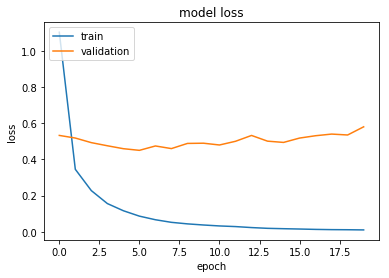

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for loss
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Looking at the learning curves, the model seems to have overfitted after a few epochs.

I'll try adding a dropout layer and see whether this will reduce overfitting.

model no.2 - one dropout layer added

In [161]:
my_model = Sequential()

# first, average pooling
my_model.add(GlobalAveragePooling2D(input_shape=trainXception.shape[1:]))

# among the pooled averages, drop out half
my_model.add(Dropout(0.5))

# finally softmax layer with 133 output nodes
my_model.add(Dense(133, activation='softmax'))

# compile
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_history = my_model.fit(trainXception, train_targets, 
                                validation_data=(validXception, valid_targets),
                                epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# load the best weights
my_model.load_weights('saved_models/weights.best.Xception.hdf5')

# predict
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in testXception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)

# store the results
Xception_results["2"] = test_accuracy

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 9s 1ms/step - loss: 1.6699 - acc: 0.5999 - val_loss: 0.5591 - val_acc: 0.8263
Epoch 2/20
6680/6680 [==============================] - 6s 878us/step - loss: 0.5982 - acc: 0.8118 - val_loss: 0.4786 - val_acc: 0.8587
Epoch 3/20


6680/6680 [==============================] - 6s 869us/step - loss: 0.4614 - acc: 0.8551 - val_loss: 0.4719 - val_acc: 0.8491
Epoch 4/20
6680/6680 [==============================] - 6s 869us/step - loss: 0.3860 - acc: 0.8750 - val_loss: 0.4608 - val_acc: 0.8455
Epoch 5/20


6680/6680 [==============================] - 6s 866us/step - loss: 0.3522 - acc: 0.8855 - val_loss: 0.4717 - val_acc: 0.8443
Epoch 6/20
6680/6680 [==============================] - 6s 866us/step - loss: 0.3025 - acc: 0.8999 - val_loss: 0.4455 - val_acc: 0.8683
Epoch 7/20


6680/6680 [==============================] - 6s 861us/step - loss: 0.2626 - acc: 0.9099 - val_loss: 0.4628 - val_acc: 0.8539
Epoch 8/20
6680/6680 [==============================] - 6s 856us/step - loss: 0.2549 - acc: 0.9142 - val_loss: 0.4865 - val_acc: 0.8575
Epoch 9/20


6680/6680 [==============================] - 6s 869us/step - loss: 0.2312 - acc: 0.9243 - val_loss: 0.4815 - val_acc: 0.8395
Epoch 10/20
6680/6680 [==============================] - 6s 872us/step - loss: 0.2040 - acc: 0.9334 - val_loss: 0.5000 - val_acc: 0.8455
Epoch 11/20


6680/6680 [==============================] - 6s 861us/step - loss: 0.2048 - acc: 0.9305 - val_loss: 0.4824 - val_acc: 0.8491
Epoch 12/20
6680/6680 [==============================] - 6s 864us/step - loss: 0.1842 - acc: 0.9370 - val_loss: 0.5136 - val_acc: 0.8539
Epoch 13/20


6680/6680 [==============================] - 6s 859us/step - loss: 0.1835 - acc: 0.9364 - val_loss: 0.5029 - val_acc: 0.8611
Epoch 14/20
6680/6680 [==============================] - 6s 866us/step - loss: 0.1710 - acc: 0.9383 - val_loss: 0.4773 - val_acc: 0.8575
Epoch 15/20


6680/6680 [==============================] - 6s 859us/step - loss: 0.1688 - acc: 0.9404 - val_loss: 0.4933 - val_acc: 0.8635
Epoch 16/20
6680/6680 [==============================] - 6s 857us/step - loss: 0.1675 - acc: 0.9380 - val_loss: 0.4850 - val_acc: 0.8527
Epoch 17/20


6680/6680 [==============================] - 6s 859us/step - loss: 0.1541 - acc: 0.9484 - val_loss: 0.5399 - val_acc: 0.8431
Epoch 18/20
6680/6680 [==============================] - 6s 857us/step - loss: 0.1515 - acc: 0.9485 - val_loss: 0.5119 - val_acc: 0.8575
Epoch 19/20


6680/6680 [==============================] - 6s 857us/step - loss: 0.1329 - acc: 0.9536 - val_loss: 0.5288 - val_acc: 0.8599
Epoch 20/20
6680/6680 [==============================] - 6s 861us/step - loss: 0.1328 - acc: 0.9539 - val_loss: 0.5297 - val_acc: 0.8563


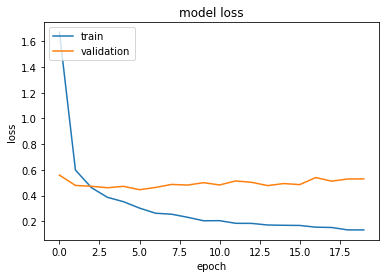

{'1': 86.004784688995215, '2': 84.330143540669852, '3': 80.861244019138752, '4': 84.569377990430624}


In [162]:
# summarize history for loss
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(Xception_results)

With one dropout layer, the test accuracy rather, decreased.

I'll try one more dense layer(between the pooling and the output layer) and see if this increases the test accuracy.

Before adding a dense layer, let's check the input shape to figure out how many nodes should the dense layer have.

In [150]:
trainXception.shape

(6680, 7, 7, 2048)

So, the average pooling layer will have the shape of (None, 2048).

That is, from 2048 nodes to 133 output nodes. I'll give 1,000 nodes to the new dense layer.

model no.3 - a dense layer(1,000 nodes) added

In [151]:
my_model = Sequential()

# first, average pooling
my_model.add(GlobalAveragePooling2D(input_shape=trainXception.shape[1:]))

# one more dense layer with 1,000 nodes
my_model.add(Dense(1000, activation='relu'))

# finally softmax layer with 133 output nodes
my_model.add(Dense(133, activation='softmax'))

# compile
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_history = my_model.fit(trainXception, train_targets, 
                                validation_data=(validXception, valid_targets),
                                epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# load the best weights
my_model.load_weights('saved_models/weights.best.Xception.hdf5')

# predict
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in testXception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)

# store the results
Xception_results["3"] = test_accuracy

Train on 6680 samples, validate on 835 samples
Epoch 1/20


4320/6680 [==================>...........] - ETA: 7:03 - loss: 4.9158 - acc: 0.0000e+0 - ETA: 3:41 - loss: 5.0064 - acc: 0.0250    - ETA: 2:33 - loss: 4.9722 - acc: 0.050 - ETA: 1:58 - loss: 4.9297 - acc: 0.050 - ETA: 1:38 - loss: 4.8819 - acc: 0.070 - ETA: 1:24 - loss: 4.6960 - acc: 0.108 - ETA: 1:15 - loss: 4.8087 - acc: 0.092 - ETA: 1:07 - loss: 4.7527 - acc: 0.100 - ETA: 1:01 - loss: 4.6689 - acc: 0.122 - ETA: 57s - loss: 4.6150 - acc: 0.130 - ETA: 53s - loss: 4.5390 - acc: 0.14 - ETA: 50s - loss: 4.4522 - acc: 0.15 - ETA: 47s - loss: 4.3774 - acc: 0.16 - ETA: 45s - loss: 4.3566 - acc: 0.17 - ETA: 43s - loss: 4.2771 - acc: 0.19 - ETA: 41s - loss: 4.2230 - acc: 0.20 - ETA: 40s - loss: 4.1377 - acc: 0.22 - ETA: 38s - loss: 4.0539 - acc: 0.23 - ETA: 37s - loss: 3.9963 - acc: 0.24 - ETA: 36s - loss: 3.9769 - acc: 0.25 - ETA: 35s - loss: 3.9351 - acc: 0.25 - ETA: 34s - loss: 3.8607 - acc: 0.26 - ETA: 33s - loss: 3.7956 - acc: 0.28 - ETA: 32s - loss: 3.7534 - acc: 0.28 - ETA: 32s - loss:

6680/6680 [==============================] - 21s 3ms/step - loss: 1.1316 - acc: 0.7067 - val_loss: 0.6421 - val_acc: 0.7808
Epoch 2/20


4540/6680 [===================>..........] - ETA: 16s - loss: 0.2003 - acc: 0.95 - ETA: 16s - loss: 0.3260 - acc: 0.87 - ETA: 17s - loss: 0.3706 - acc: 0.86 - ETA: 17s - loss: 0.3660 - acc: 0.86 - ETA: 17s - loss: 0.3419 - acc: 0.87 - ETA: 17s - loss: 0.3695 - acc: 0.85 - ETA: 17s - loss: 0.3283 - acc: 0.87 - ETA: 17s - loss: 0.3674 - acc: 0.86 - ETA: 17s - loss: 0.3924 - acc: 0.85 - ETA: 16s - loss: 0.4073 - acc: 0.85 - ETA: 16s - loss: 0.3977 - acc: 0.86 - ETA: 16s - loss: 0.4466 - acc: 0.84 - ETA: 16s - loss: 0.4440 - acc: 0.84 - ETA: 16s - loss: 0.4331 - acc: 0.84 - ETA: 16s - loss: 0.4384 - acc: 0.84 - ETA: 16s - loss: 0.4262 - acc: 0.84 - ETA: 16s - loss: 0.4127 - acc: 0.85 - ETA: 16s - loss: 0.3976 - acc: 0.86 - ETA: 16s - loss: 0.3887 - acc: 0.86 - ETA: 16s - loss: 0.3822 - acc: 0.87 - ETA: 16s - loss: 0.3999 - acc: 0.86 - ETA: 16s - loss: 0.3944 - acc: 0.87 - ETA: 16s - loss: 0.4136 - acc: 0.86 - ETA: 16s - loss: 0.4078 - acc: 0.86 - ETA: 16s - loss: 0.3992 - acc: 0.86 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.4484 - acc: 0.8578 - val_loss: 0.6936 - val_acc: 0.8000
Epoch 3/20


4460/6680 [===================>..........] - ETA: 16s - loss: 0.2286 - acc: 0.90 - ETA: 16s - loss: 0.3597 - acc: 0.82 - ETA: 17s - loss: 0.2679 - acc: 0.88 - ETA: 17s - loss: 0.2688 - acc: 0.90 - ETA: 17s - loss: 0.2481 - acc: 0.91 - ETA: 17s - loss: 0.2254 - acc: 0.92 - ETA: 17s - loss: 0.2494 - acc: 0.92 - ETA: 17s - loss: 0.2309 - acc: 0.93 - ETA: 17s - loss: 0.2494 - acc: 0.92 - ETA: 17s - loss: 0.2443 - acc: 0.93 - ETA: 17s - loss: 0.2642 - acc: 0.91 - ETA: 17s - loss: 0.2895 - acc: 0.90 - ETA: 17s - loss: 0.2830 - acc: 0.90 - ETA: 17s - loss: 0.2884 - acc: 0.90 - ETA: 17s - loss: 0.2833 - acc: 0.90 - ETA: 17s - loss: 0.2766 - acc: 0.90 - ETA: 17s - loss: 0.2956 - acc: 0.90 - ETA: 17s - loss: 0.2849 - acc: 0.90 - ETA: 17s - loss: 0.2893 - acc: 0.90 - ETA: 16s - loss: 0.2824 - acc: 0.90 - ETA: 16s - loss: 0.3119 - acc: 0.90 - ETA: 16s - loss: 0.3204 - acc: 0.90 - ETA: 16s - loss: 0.3209 - acc: 0.90 - ETA: 16s - loss: 0.3260 - acc: 0.89 - ETA: 16s - loss: 0.3162 - acc: 0.89 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.3049 - acc: 0.9001 - val_loss: 0.6437 - val_acc: 0.8144
Epoch 4/20


4480/6680 [===================>..........] - ETA: 16s - loss: 0.3419 - acc: 0.85 - ETA: 17s - loss: 0.2434 - acc: 0.90 - ETA: 17s - loss: 0.2303 - acc: 0.90 - ETA: 17s - loss: 0.2647 - acc: 0.90 - ETA: 17s - loss: 0.2485 - acc: 0.90 - ETA: 17s - loss: 0.2237 - acc: 0.90 - ETA: 17s - loss: 0.2224 - acc: 0.90 - ETA: 17s - loss: 0.2039 - acc: 0.91 - ETA: 16s - loss: 0.2188 - acc: 0.90 - ETA: 16s - loss: 0.2065 - acc: 0.90 - ETA: 16s - loss: 0.2009 - acc: 0.91 - ETA: 16s - loss: 0.2134 - acc: 0.91 - ETA: 16s - loss: 0.2098 - acc: 0.91 - ETA: 16s - loss: 0.2589 - acc: 0.90 - ETA: 16s - loss: 0.2722 - acc: 0.90 - ETA: 16s - loss: 0.2630 - acc: 0.90 - ETA: 16s - loss: 0.2613 - acc: 0.90 - ETA: 16s - loss: 0.2612 - acc: 0.90 - ETA: 16s - loss: 0.2578 - acc: 0.90 - ETA: 16s - loss: 0.2472 - acc: 0.90 - ETA: 16s - loss: 0.2537 - acc: 0.90 - ETA: 16s - loss: 0.2516 - acc: 0.90 - ETA: 16s - loss: 0.2454 - acc: 0.91 - ETA: 16s - loss: 0.2413 - acc: 0.91 - ETA: 16s - loss: 0.2372 - acc: 0.91 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.2181 - acc: 0.9260 - val_loss: 0.6420 - val_acc: 0.8156
Epoch 5/20


4420/6680 [==================>...........] - ETA: 15s - loss: 0.1180 - acc: 0.95 - ETA: 15s - loss: 0.0676 - acc: 0.97 - ETA: 16s - loss: 0.0938 - acc: 0.95 - ETA: 16s - loss: 0.1144 - acc: 0.93 - ETA: 16s - loss: 0.1271 - acc: 0.93 - ETA: 16s - loss: 0.1807 - acc: 0.92 - ETA: 16s - loss: 0.1750 - acc: 0.92 - ETA: 16s - loss: 0.1776 - acc: 0.92 - ETA: 16s - loss: 0.1689 - acc: 0.92 - ETA: 16s - loss: 0.1655 - acc: 0.93 - ETA: 16s - loss: 0.1509 - acc: 0.93 - ETA: 16s - loss: 0.1645 - acc: 0.93 - ETA: 16s - loss: 0.1533 - acc: 0.94 - ETA: 16s - loss: 0.1544 - acc: 0.94 - ETA: 16s - loss: 0.1520 - acc: 0.94 - ETA: 16s - loss: 0.1526 - acc: 0.94 - ETA: 16s - loss: 0.1509 - acc: 0.94 - ETA: 16s - loss: 0.1430 - acc: 0.95 - ETA: 16s - loss: 0.1441 - acc: 0.95 - ETA: 16s - loss: 0.1381 - acc: 0.95 - ETA: 16s - loss: 0.1362 - acc: 0.95 - ETA: 16s - loss: 0.1394 - acc: 0.95 - ETA: 16s - loss: 0.1395 - acc: 0.95 - ETA: 16s - loss: 0.1354 - acc: 0.95 - ETA: 16s - loss: 0.1367 - acc: 0.95 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.1655 - acc: 0.9443 - val_loss: 0.6954 - val_acc: 0.8204
Epoch 6/20


4400/6680 [==================>...........] - ETA: 16s - loss: 0.0498 - acc: 1.00 - ETA: 16s - loss: 0.1281 - acc: 0.97 - ETA: 16s - loss: 0.1218 - acc: 0.96 - ETA: 16s - loss: 0.1997 - acc: 0.93 - ETA: 16s - loss: 0.2068 - acc: 0.94 - ETA: 17s - loss: 0.1779 - acc: 0.95 - ETA: 17s - loss: 0.1546 - acc: 0.95 - ETA: 16s - loss: 0.1494 - acc: 0.95 - ETA: 17s - loss: 0.1434 - acc: 0.96 - ETA: 17s - loss: 0.1652 - acc: 0.96 - ETA: 17s - loss: 0.1561 - acc: 0.96 - ETA: 16s - loss: 0.1555 - acc: 0.96 - ETA: 16s - loss: 0.1560 - acc: 0.96 - ETA: 16s - loss: 0.1464 - acc: 0.96 - ETA: 16s - loss: 0.1388 - acc: 0.96 - ETA: 16s - loss: 0.1355 - acc: 0.96 - ETA: 16s - loss: 0.1484 - acc: 0.95 - ETA: 16s - loss: 0.1425 - acc: 0.96 - ETA: 16s - loss: 0.1430 - acc: 0.95 - ETA: 16s - loss: 0.1417 - acc: 0.95 - ETA: 16s - loss: 0.1383 - acc: 0.95 - ETA: 16s - loss: 0.1344 - acc: 0.96 - ETA: 16s - loss: 0.1298 - acc: 0.96 - ETA: 16s - loss: 0.1314 - acc: 0.96 - ETA: 16s - loss: 0.1291 - acc: 0.96 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.1272 - acc: 0.9572 - val_loss: 0.7596 - val_acc: 0.8144
Epoch 7/20


4440/6680 [==================>...........] - ETA: 15s - loss: 0.0497 - acc: 1.00 - ETA: 16s - loss: 0.0330 - acc: 1.00 - ETA: 16s - loss: 0.0262 - acc: 1.00 - ETA: 16s - loss: 0.0681 - acc: 0.97 - ETA: 17s - loss: 0.0854 - acc: 0.97 - ETA: 17s - loss: 0.1260 - acc: 0.95 - ETA: 17s - loss: 0.1216 - acc: 0.95 - ETA: 17s - loss: 0.1104 - acc: 0.95 - ETA: 17s - loss: 0.1025 - acc: 0.96 - ETA: 17s - loss: 0.0925 - acc: 0.96 - ETA: 17s - loss: 0.1171 - acc: 0.95 - ETA: 17s - loss: 0.1275 - acc: 0.95 - ETA: 17s - loss: 0.1347 - acc: 0.95 - ETA: 17s - loss: 0.1309 - acc: 0.95 - ETA: 17s - loss: 0.1343 - acc: 0.95 - ETA: 17s - loss: 0.1317 - acc: 0.95 - ETA: 17s - loss: 0.1268 - acc: 0.95 - ETA: 16s - loss: 0.1218 - acc: 0.95 - ETA: 16s - loss: 0.1183 - acc: 0.96 - ETA: 16s - loss: 0.1268 - acc: 0.95 - ETA: 16s - loss: 0.1216 - acc: 0.95 - ETA: 16s - loss: 0.1209 - acc: 0.95 - ETA: 16s - loss: 0.1205 - acc: 0.95 - ETA: 16s - loss: 0.1179 - acc: 0.96 - ETA: 16s - loss: 0.1273 - acc: 0.95 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.1204 - acc: 0.9626 - val_loss: 0.7331 - val_acc: 0.8096
Epoch 8/20


4360/6680 [==================>...........] - ETA: 16s - loss: 0.0027 - acc: 1.00 - ETA: 17s - loss: 0.0194 - acc: 1.00 - ETA: 17s - loss: 0.0140 - acc: 1.00 - ETA: 17s - loss: 0.0124 - acc: 1.00 - ETA: 17s - loss: 0.0216 - acc: 0.99 - ETA: 17s - loss: 0.0222 - acc: 0.99 - ETA: 17s - loss: 0.0266 - acc: 0.99 - ETA: 17s - loss: 0.0412 - acc: 0.98 - ETA: 17s - loss: 0.0405 - acc: 0.98 - ETA: 17s - loss: 0.0386 - acc: 0.99 - ETA: 17s - loss: 0.0420 - acc: 0.98 - ETA: 17s - loss: 0.0455 - acc: 0.98 - ETA: 17s - loss: 0.0437 - acc: 0.98 - ETA: 17s - loss: 0.0420 - acc: 0.98 - ETA: 17s - loss: 0.0549 - acc: 0.98 - ETA: 17s - loss: 0.0561 - acc: 0.98 - ETA: 17s - loss: 0.0541 - acc: 0.98 - ETA: 17s - loss: 0.0516 - acc: 0.98 - ETA: 17s - loss: 0.0624 - acc: 0.98 - ETA: 17s - loss: 0.0616 - acc: 0.98 - ETA: 17s - loss: 0.0627 - acc: 0.98 - ETA: 17s - loss: 0.0655 - acc: 0.97 - ETA: 17s - loss: 0.0651 - acc: 0.98 - ETA: 17s - loss: 0.0626 - acc: 0.98 - ETA: 16s - loss: 0.0625 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.1042 - acc: 0.9692 - val_loss: 0.7209 - val_acc: 0.8096
Epoch 9/20


4380/6680 [==================>...........] - ETA: 15s - loss: 0.1490 - acc: 0.90 - ETA: 17s - loss: 0.1404 - acc: 0.92 - ETA: 17s - loss: 0.0956 - acc: 0.95 - ETA: 17s - loss: 0.0830 - acc: 0.95 - ETA: 17s - loss: 0.0687 - acc: 0.96 - ETA: 17s - loss: 0.1061 - acc: 0.95 - ETA: 17s - loss: 0.0947 - acc: 0.95 - ETA: 17s - loss: 0.1118 - acc: 0.95 - ETA: 17s - loss: 0.1016 - acc: 0.96 - ETA: 17s - loss: 0.1067 - acc: 0.96 - ETA: 17s - loss: 0.1007 - acc: 0.96 - ETA: 17s - loss: 0.1016 - acc: 0.96 - ETA: 16s - loss: 0.1066 - acc: 0.96 - ETA: 16s - loss: 0.1080 - acc: 0.96 - ETA: 16s - loss: 0.1052 - acc: 0.96 - ETA: 16s - loss: 0.0991 - acc: 0.96 - ETA: 16s - loss: 0.0977 - acc: 0.96 - ETA: 16s - loss: 0.0945 - acc: 0.96 - ETA: 16s - loss: 0.0914 - acc: 0.96 - ETA: 16s - loss: 0.0874 - acc: 0.96 - ETA: 16s - loss: 0.0834 - acc: 0.96 - ETA: 16s - loss: 0.0888 - acc: 0.96 - ETA: 16s - loss: 0.0874 - acc: 0.96 - ETA: 16s - loss: 0.0878 - acc: 0.96 - ETA: 16s - loss: 0.0937 - acc: 0.96 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.0899 - acc: 0.9722 - val_loss: 0.7255 - val_acc: 0.8275
Epoch 10/20


4340/6680 [==================>...........] - ETA: 16s - loss: 0.0109 - acc: 1.00 - ETA: 17s - loss: 0.0192 - acc: 1.00 - ETA: 17s - loss: 0.0158 - acc: 1.00 - ETA: 17s - loss: 0.0350 - acc: 0.97 - ETA: 17s - loss: 0.0454 - acc: 0.97 - ETA: 17s - loss: 0.0389 - acc: 0.97 - ETA: 17s - loss: 0.0396 - acc: 0.97 - ETA: 17s - loss: 0.0369 - acc: 0.97 - ETA: 17s - loss: 0.0347 - acc: 0.97 - ETA: 17s - loss: 0.0475 - acc: 0.97 - ETA: 17s - loss: 0.0441 - acc: 0.97 - ETA: 17s - loss: 0.0424 - acc: 0.97 - ETA: 17s - loss: 0.0405 - acc: 0.98 - ETA: 17s - loss: 0.0381 - acc: 0.98 - ETA: 17s - loss: 0.0362 - acc: 0.98 - ETA: 17s - loss: 0.0424 - acc: 0.98 - ETA: 17s - loss: 0.0440 - acc: 0.97 - ETA: 17s - loss: 0.0708 - acc: 0.96 - ETA: 17s - loss: 0.0688 - acc: 0.97 - ETA: 17s - loss: 0.0663 - acc: 0.97 - ETA: 17s - loss: 0.0633 - acc: 0.97 - ETA: 17s - loss: 0.0648 - acc: 0.97 - ETA: 17s - loss: 0.0773 - acc: 0.96 - ETA: 17s - loss: 0.0801 - acc: 0.96 - ETA: 16s - loss: 0.0827 - acc: 0.96 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.1155 - acc: 0.9632 - val_loss: 0.7746 - val_acc: 0.7976
Epoch 11/20


4380/6680 [==================>...........] - ETA: 16s - loss: 0.0761 - acc: 1.00 - ETA: 17s - loss: 0.0424 - acc: 1.00 - ETA: 16s - loss: 0.0434 - acc: 1.00 - ETA: 17s - loss: 0.0398 - acc: 1.00 - ETA: 17s - loss: 0.0355 - acc: 1.00 - ETA: 17s - loss: 0.0324 - acc: 1.00 - ETA: 17s - loss: 0.0290 - acc: 1.00 - ETA: 17s - loss: 0.0267 - acc: 1.00 - ETA: 17s - loss: 0.0297 - acc: 1.00 - ETA: 17s - loss: 0.0320 - acc: 1.00 - ETA: 17s - loss: 0.0397 - acc: 0.99 - ETA: 17s - loss: 0.0408 - acc: 0.99 - ETA: 17s - loss: 0.0570 - acc: 0.98 - ETA: 17s - loss: 0.0599 - acc: 0.98 - ETA: 17s - loss: 0.0583 - acc: 0.98 - ETA: 17s - loss: 0.0585 - acc: 0.98 - ETA: 17s - loss: 0.0606 - acc: 0.98 - ETA: 17s - loss: 0.0715 - acc: 0.98 - ETA: 17s - loss: 0.0778 - acc: 0.98 - ETA: 17s - loss: 0.0750 - acc: 0.98 - ETA: 17s - loss: 0.0756 - acc: 0.98 - ETA: 17s - loss: 0.0829 - acc: 0.97 - ETA: 17s - loss: 0.0794 - acc: 0.98 - ETA: 17s - loss: 0.0767 - acc: 0.98 - ETA: 16s - loss: 0.0764 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.0777 - acc: 0.9756 - val_loss: 0.8011 - val_acc: 0.8228
Epoch 12/20


4460/6680 [===================>..........] - ETA: 15s - loss: 0.1288 - acc: 0.95 - ETA: 16s - loss: 0.1169 - acc: 0.95 - ETA: 15s - loss: 0.1051 - acc: 0.96 - ETA: 16s - loss: 0.0845 - acc: 0.97 - ETA: 16s - loss: 0.0739 - acc: 0.97 - ETA: 16s - loss: 0.0687 - acc: 0.97 - ETA: 16s - loss: 0.0658 - acc: 0.98 - ETA: 16s - loss: 0.0662 - acc: 0.98 - ETA: 16s - loss: 0.0694 - acc: 0.98 - ETA: 16s - loss: 0.0759 - acc: 0.97 - ETA: 16s - loss: 0.0757 - acc: 0.97 - ETA: 16s - loss: 0.0724 - acc: 0.98 - ETA: 16s - loss: 0.0838 - acc: 0.97 - ETA: 16s - loss: 0.0787 - acc: 0.98 - ETA: 16s - loss: 0.0756 - acc: 0.98 - ETA: 16s - loss: 0.0713 - acc: 0.98 - ETA: 16s - loss: 0.0690 - acc: 0.98 - ETA: 16s - loss: 0.0662 - acc: 0.98 - ETA: 16s - loss: 0.0632 - acc: 0.98 - ETA: 16s - loss: 0.0606 - acc: 0.98 - ETA: 16s - loss: 0.0584 - acc: 0.98 - ETA: 16s - loss: 0.0627 - acc: 0.98 - ETA: 16s - loss: 0.0615 - acc: 0.98 - ETA: 16s - loss: 0.0591 - acc: 0.98 - ETA: 16s - loss: 0.0573 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.0747 - acc: 0.9790 - val_loss: 0.7358 - val_acc: 0.8287
Epoch 13/20


4520/6680 [===================>..........] - ETA: 16s - loss: 0.0252 - acc: 1.00 - ETA: 16s - loss: 0.0289 - acc: 1.00 - ETA: 16s - loss: 0.1203 - acc: 0.96 - ETA: 17s - loss: 0.0912 - acc: 0.97 - ETA: 17s - loss: 0.0745 - acc: 0.98 - ETA: 17s - loss: 0.0658 - acc: 0.98 - ETA: 17s - loss: 0.0566 - acc: 0.98 - ETA: 17s - loss: 0.0541 - acc: 0.98 - ETA: 17s - loss: 0.0490 - acc: 0.98 - ETA: 17s - loss: 0.0549 - acc: 0.98 - ETA: 16s - loss: 0.0504 - acc: 0.98 - ETA: 17s - loss: 0.0701 - acc: 0.98 - ETA: 16s - loss: 0.0655 - acc: 0.98 - ETA: 16s - loss: 0.0619 - acc: 0.98 - ETA: 16s - loss: 0.0593 - acc: 0.98 - ETA: 16s - loss: 0.0636 - acc: 0.98 - ETA: 16s - loss: 0.0606 - acc: 0.98 - ETA: 16s - loss: 0.0574 - acc: 0.98 - ETA: 16s - loss: 0.0546 - acc: 0.98 - ETA: 16s - loss: 0.0539 - acc: 0.98 - ETA: 16s - loss: 0.0522 - acc: 0.98 - ETA: 16s - loss: 0.0507 - acc: 0.98 - ETA: 16s - loss: 0.0496 - acc: 0.98 - ETA: 16s - loss: 0.0812 - acc: 0.98 - ETA: 16s - loss: 0.0788 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.0719 - acc: 0.9780 - val_loss: 0.8871 - val_acc: 0.8192
Epoch 14/20


4320/6680 [==================>...........] - ETA: 16s - loss: 0.0160 - acc: 1.00 - ETA: 16s - loss: 0.0165 - acc: 1.00 - ETA: 16s - loss: 0.0128 - acc: 1.00 - ETA: 17s - loss: 0.0134 - acc: 1.00 - ETA: 17s - loss: 0.0355 - acc: 0.99 - ETA: 17s - loss: 0.1384 - acc: 0.97 - ETA: 17s - loss: 0.1190 - acc: 0.97 - ETA: 17s - loss: 0.1058 - acc: 0.98 - ETA: 17s - loss: 0.1097 - acc: 0.97 - ETA: 17s - loss: 0.0989 - acc: 0.98 - ETA: 17s - loss: 0.1198 - acc: 0.97 - ETA: 17s - loss: 0.1369 - acc: 0.97 - ETA: 17s - loss: 0.1286 - acc: 0.97 - ETA: 17s - loss: 0.1285 - acc: 0.97 - ETA: 17s - loss: 0.1218 - acc: 0.97 - ETA: 17s - loss: 0.1143 - acc: 0.97 - ETA: 16s - loss: 0.1123 - acc: 0.97 - ETA: 16s - loss: 0.1063 - acc: 0.97 - ETA: 16s - loss: 0.1027 - acc: 0.97 - ETA: 16s - loss: 0.0983 - acc: 0.97 - ETA: 16s - loss: 0.0938 - acc: 0.97 - ETA: 16s - loss: 0.0906 - acc: 0.97 - ETA: 16s - loss: 0.0899 - acc: 0.97 - ETA: 16s - loss: 0.0863 - acc: 0.97 - ETA: 16s - loss: 0.0829 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.0661 - acc: 0.9813 - val_loss: 0.8708 - val_acc: 0.8263
Epoch 15/20


4400/6680 [==================>...........] - ETA: 16s - loss: 8.4556e-04 - acc: 1.00 - ETA: 16s - loss: 0.0050 - acc: 1.0000   - ETA: 17s - loss: 0.0301 - acc: 0.98 - ETA: 17s - loss: 0.0263 - acc: 0.98 - ETA: 17s - loss: 0.0258 - acc: 0.99 - ETA: 17s - loss: 0.0289 - acc: 0.99 - ETA: 17s - loss: 0.0252 - acc: 0.99 - ETA: 17s - loss: 0.0470 - acc: 0.98 - ETA: 17s - loss: 0.0423 - acc: 0.98 - ETA: 17s - loss: 0.0394 - acc: 0.99 - ETA: 17s - loss: 0.0376 - acc: 0.99 - ETA: 17s - loss: 0.0422 - acc: 0.98 - ETA: 16s - loss: 0.0363 - acc: 0.98 - ETA: 16s - loss: 0.0340 - acc: 0.99 - ETA: 16s - loss: 0.0343 - acc: 0.99 - ETA: 16s - loss: 0.0324 - acc: 0.99 - ETA: 16s - loss: 0.0307 - acc: 0.99 - ETA: 16s - loss: 0.0306 - acc: 0.99 - ETA: 16s - loss: 0.0294 - acc: 0.99 - ETA: 16s - loss: 0.0295 - acc: 0.99 - ETA: 16s - loss: 0.0283 - acc: 0.99 - ETA: 16s - loss: 0.0274 - acc: 0.99 - ETA: 16s - loss: 0.0264 - acc: 0.99 - ETA: 16s - loss: 0.0280 - acc: 0.99 - ETA: 16s - loss: 0.0270 - acc: 0.99

6680/6680 [==============================] - 18s 3ms/step - loss: 0.0971 - acc: 0.9713 - val_loss: 0.9738 - val_acc: 0.8108
Epoch 16/20


4380/6680 [==================>...........] - ETA: 16s - loss: 0.1597 - acc: 0.95 - ETA: 17s - loss: 0.0860 - acc: 0.97 - ETA: 17s - loss: 0.1037 - acc: 0.95 - ETA: 17s - loss: 0.0933 - acc: 0.95 - ETA: 17s - loss: 0.0834 - acc: 0.96 - ETA: 18s - loss: 0.0752 - acc: 0.96 - ETA: 17s - loss: 0.1050 - acc: 0.95 - ETA: 17s - loss: 0.1031 - acc: 0.95 - ETA: 17s - loss: 0.1484 - acc: 0.94 - ETA: 17s - loss: 0.1553 - acc: 0.94 - ETA: 17s - loss: 0.1574 - acc: 0.94 - ETA: 17s - loss: 0.1456 - acc: 0.95 - ETA: 17s - loss: 0.1349 - acc: 0.95 - ETA: 17s - loss: 0.1269 - acc: 0.95 - ETA: 17s - loss: 0.1197 - acc: 0.96 - ETA: 17s - loss: 0.1317 - acc: 0.95 - ETA: 17s - loss: 0.1262 - acc: 0.96 - ETA: 17s - loss: 0.1267 - acc: 0.96 - ETA: 17s - loss: 0.1204 - acc: 0.96 - ETA: 17s - loss: 0.1253 - acc: 0.96 - ETA: 17s - loss: 0.1194 - acc: 0.96 - ETA: 16s - loss: 0.1326 - acc: 0.95 - ETA: 16s - loss: 0.1301 - acc: 0.95 - ETA: 16s - loss: 0.1251 - acc: 0.95 - ETA: 16s - loss: 0.1214 - acc: 0.96 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.1181 - acc: 0.9659 - val_loss: 1.0323 - val_acc: 0.8108
Epoch 17/20


4400/6680 [==================>...........] - ETA: 15s - loss: 0.1736 - acc: 0.95 - ETA: 16s - loss: 0.0930 - acc: 0.97 - ETA: 17s - loss: 0.1152 - acc: 0.95 - ETA: 17s - loss: 0.2136 - acc: 0.92 - ETA: 17s - loss: 0.1781 - acc: 0.94 - ETA: 17s - loss: 0.1490 - acc: 0.95 - ETA: 17s - loss: 0.1325 - acc: 0.95 - ETA: 17s - loss: 0.1165 - acc: 0.96 - ETA: 17s - loss: 0.1041 - acc: 0.96 - ETA: 17s - loss: 0.1028 - acc: 0.97 - ETA: 16s - loss: 0.0962 - acc: 0.97 - ETA: 16s - loss: 0.0930 - acc: 0.97 - ETA: 16s - loss: 0.0949 - acc: 0.96 - ETA: 16s - loss: 0.0951 - acc: 0.96 - ETA: 16s - loss: 0.0996 - acc: 0.96 - ETA: 16s - loss: 0.0934 - acc: 0.96 - ETA: 16s - loss: 0.0937 - acc: 0.96 - ETA: 16s - loss: 0.0915 - acc: 0.96 - ETA: 16s - loss: 0.0950 - acc: 0.96 - ETA: 16s - loss: 0.0912 - acc: 0.96 - ETA: 16s - loss: 0.0874 - acc: 0.96 - ETA: 16s - loss: 0.0878 - acc: 0.96 - ETA: 16s - loss: 0.0844 - acc: 0.96 - ETA: 16s - loss: 0.0809 - acc: 0.97 - ETA: 16s - loss: 0.0779 - acc: 0.97 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.0779 - acc: 0.9774 - val_loss: 0.8657 - val_acc: 0.8503
Epoch 18/20


4420/6680 [==================>...........] - ETA: 15s - loss: 0.0081 - acc: 1.00 - ETA: 16s - loss: 0.0192 - acc: 1.00 - ETA: 16s - loss: 0.0491 - acc: 0.98 - ETA: 17s - loss: 0.0419 - acc: 0.98 - ETA: 17s - loss: 0.0349 - acc: 0.99 - ETA: 17s - loss: 0.0305 - acc: 0.99 - ETA: 17s - loss: 0.0285 - acc: 0.99 - ETA: 17s - loss: 0.0254 - acc: 0.99 - ETA: 17s - loss: 0.0261 - acc: 0.99 - ETA: 17s - loss: 0.0240 - acc: 0.99 - ETA: 17s - loss: 0.0228 - acc: 0.99 - ETA: 17s - loss: 0.0217 - acc: 0.99 - ETA: 17s - loss: 0.0208 - acc: 0.99 - ETA: 17s - loss: 0.0195 - acc: 0.99 - ETA: 17s - loss: 0.0196 - acc: 0.99 - ETA: 16s - loss: 0.0299 - acc: 0.99 - ETA: 16s - loss: 0.0740 - acc: 0.98 - ETA: 16s - loss: 0.0702 - acc: 0.98 - ETA: 16s - loss: 0.0669 - acc: 0.99 - ETA: 16s - loss: 0.0924 - acc: 0.98 - ETA: 16s - loss: 0.0883 - acc: 0.98 - ETA: 16s - loss: 0.1034 - acc: 0.98 - ETA: 16s - loss: 0.1109 - acc: 0.98 - ETA: 16s - loss: 0.1067 - acc: 0.98 - ETA: 16s - loss: 0.1137 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.0511 - acc: 0.9859 - val_loss: 0.9285 - val_acc: 0.8347
Epoch 19/20


4460/6680 [===================>..........] - ETA: 16s - loss: 0.0036 - acc: 1.00 - ETA: 16s - loss: 0.0033 - acc: 1.00 - ETA: 17s - loss: 0.0167 - acc: 0.98 - ETA: 17s - loss: 0.0133 - acc: 0.98 - ETA: 17s - loss: 0.0110 - acc: 0.99 - ETA: 17s - loss: 0.0351 - acc: 0.98 - ETA: 17s - loss: 0.0301 - acc: 0.98 - ETA: 17s - loss: 0.0265 - acc: 0.98 - ETA: 17s - loss: 0.0237 - acc: 0.98 - ETA: 17s - loss: 0.0232 - acc: 0.99 - ETA: 17s - loss: 0.0232 - acc: 0.99 - ETA: 17s - loss: 0.0213 - acc: 0.99 - ETA: 17s - loss: 0.0203 - acc: 0.99 - ETA: 17s - loss: 0.0192 - acc: 0.99 - ETA: 17s - loss: 0.0180 - acc: 0.99 - ETA: 17s - loss: 0.0169 - acc: 0.99 - ETA: 17s - loss: 0.0196 - acc: 0.99 - ETA: 17s - loss: 0.0292 - acc: 0.98 - ETA: 17s - loss: 0.0277 - acc: 0.98 - ETA: 17s - loss: 0.0380 - acc: 0.98 - ETA: 17s - loss: 0.0477 - acc: 0.98 - ETA: 17s - loss: 0.0774 - acc: 0.98 - ETA: 17s - loss: 0.0820 - acc: 0.98 - ETA: 16s - loss: 0.0795 - acc: 0.98 - ETA: 17s - loss: 0.0765 - acc: 0.98 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.0524 - acc: 0.9861 - val_loss: 0.7944 - val_acc: 0.8467
Epoch 20/20


4460/6680 [===================>..........] - ETA: 16s - loss: 5.7247e-04 - acc: 1.00 - ETA: 16s - loss: 7.7995e-04 - acc: 1.00 - ETA: 16s - loss: 0.0087 - acc: 1.0000   - ETA: 16s - loss: 0.0353 - acc: 0.99 - ETA: 16s - loss: 0.0302 - acc: 0.99 - ETA: 16s - loss: 0.0261 - acc: 0.99 - ETA: 16s - loss: 0.0234 - acc: 0.99 - ETA: 17s - loss: 0.0210 - acc: 0.99 - ETA: 17s - loss: 0.0190 - acc: 0.99 - ETA: 17s - loss: 0.0201 - acc: 0.99 - ETA: 17s - loss: 0.0190 - acc: 0.99 - ETA: 17s - loss: 0.0178 - acc: 0.99 - ETA: 17s - loss: 0.0167 - acc: 0.99 - ETA: 17s - loss: 0.0199 - acc: 0.99 - ETA: 17s - loss: 0.0188 - acc: 0.99 - ETA: 17s - loss: 0.0188 - acc: 0.99 - ETA: 16s - loss: 0.0182 - acc: 0.99 - ETA: 16s - loss: 0.0191 - acc: 0.99 - ETA: 16s - loss: 0.0183 - acc: 0.99 - ETA: 16s - loss: 0.0177 - acc: 0.99 - ETA: 16s - loss: 0.0169 - acc: 0.99 - ETA: 16s - loss: 0.0162 - acc: 0.99 - ETA: 16s - loss: 0.0157 - acc: 0.99 - ETA: 16s - loss: 0.0162 - acc: 0.99 - ETA: 16s - loss: 0.0169 - acc: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.0425 - acc: 0.9883 - val_loss: 0.9756 - val_acc: 0.8323


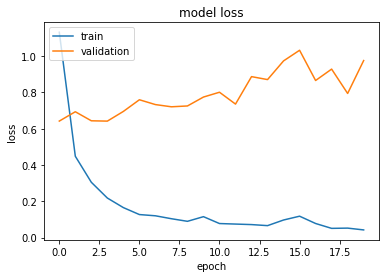

{'1': 86.004784688995215, '2': 85.047846889952154, '3': 80.861244019138752}


In [152]:
# summarize history for loss
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(Xception_results)

It got even worse. Adding a layer doesn't help.

Now, I'll try adding a dropout layer after the additional dense layer.

model no.4 - one more dropout layer

In [177]:
my_model = Sequential()

# dropout before pooling
my_model.add(GlobalAveragePooling2D(input_shape=trainXception.shape[1:]))
my_model.add(Dropout(0.5))
my_model.add(Dense(1000, activation='relu'))
my_model.add(Dropout(0.5))

my_model.add(Dense(133, activation='softmax'))

# compile
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_history = my_model.fit(trainXception, train_targets, 
                                validation_data=(validXception, valid_targets),
                                epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# load the best weights
my_model.load_weights('saved_models/weights.best.Xception.hdf5')

# predict
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in testXception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)

# store the results
Xception_results["4"] = test_accuracy

Train on 6680 samples, validate on 835 samples
Epoch 1/20


4260/6680 [==================>...........] - ETA: 8:28 - loss: 5.1145 - acc: 0.0000e+0 - ETA: 4:25 - loss: 4.9898 - acc: 0.0250    - ETA: 3:03 - loss: 4.9731 - acc: 0.033 - ETA: 2:21 - loss: 5.0105 - acc: 0.025 - ETA: 1:57 - loss: 5.1042 - acc: 0.030 - ETA: 1:40 - loss: 5.0284 - acc: 0.041 - ETA: 1:28 - loss: 5.0110 - acc: 0.057 - ETA: 1:20 - loss: 5.0242 - acc: 0.056 - ETA: 1:13 - loss: 4.8776 - acc: 0.072 - ETA: 1:07 - loss: 4.9023 - acc: 0.080 - ETA: 1:02 - loss: 4.8924 - acc: 0.081 - ETA: 59s - loss: 4.8468 - acc: 0.095 - ETA: 55s - loss: 4.8335 - acc: 0.10 - ETA: 53s - loss: 4.8206 - acc: 0.10 - ETA: 50s - loss: 4.8237 - acc: 0.11 - ETA: 48s - loss: 4.7800 - acc: 0.12 - ETA: 46s - loss: 4.7773 - acc: 0.11 - ETA: 45s - loss: 4.7358 - acc: 0.11 - ETA: 43s - loss: 4.7036 - acc: 0.12 - ETA: 42s - loss: 4.6557 - acc: 0.13 - ETA: 41s - loss: 4.6639 - acc: 0.13 - ETA: 39s - loss: 4.6411 - acc: 0.13 - ETA: 38s - loss: 4.6194 - acc: 0.13 - ETA: 37s - loss: 4.6269 - acc: 0.13 - ETA: 37s - l

6680/6680 [==============================] - 23s 3ms/step - loss: 1.6770 - acc: 0.5997 - val_loss: 0.6796 - val_acc: 0.7772
Epoch 2/20


6120/6680 [==========================>...] - ETA: 15s - loss: 0.8455 - acc: 0.75 - ETA: 17s - loss: 0.9432 - acc: 0.77 - ETA: 17s - loss: 0.8330 - acc: 0.76 - ETA: 17s - loss: 0.8403 - acc: 0.76 - ETA: 16s - loss: 0.8514 - acc: 0.76 - ETA: 16s - loss: 0.7791 - acc: 0.76 - ETA: 16s - loss: 0.7579 - acc: 0.79 - ETA: 16s - loss: 0.7554 - acc: 0.79 - ETA: 16s - loss: 0.7654 - acc: 0.79 - ETA: 16s - loss: 0.7490 - acc: 0.79 - ETA: 16s - loss: 0.7665 - acc: 0.79 - ETA: 16s - loss: 0.7443 - acc: 0.79 - ETA: 16s - loss: 0.7190 - acc: 0.80 - ETA: 15s - loss: 0.7153 - acc: 0.80 - ETA: 15s - loss: 0.7315 - acc: 0.80 - ETA: 15s - loss: 0.7371 - acc: 0.80 - ETA: 15s - loss: 0.7235 - acc: 0.80 - ETA: 15s - loss: 0.7302 - acc: 0.79 - ETA: 15s - loss: 0.7161 - acc: 0.79 - ETA: 15s - loss: 0.7163 - acc: 0.78 - ETA: 15s - loss: 0.7169 - acc: 0.78 - ETA: 15s - loss: 0.7155 - acc: 0.78 - ETA: 15s - loss: 0.7239 - acc: 0.78 - ETA: 14s - loss: 0.7393 - acc: 0.78 - ETA: 14s - loss: 0.7366 - acc: 0.78 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.7759 - acc: 0.7707 - val_loss: 0.5834 - val_acc: 0.8084
Epoch 3/20


5220/6680 [======================>.......] - ETA: 15s - loss: 0.3465 - acc: 0.85 - ETA: 19s - loss: 0.3410 - acc: 0.82 - ETA: 17s - loss: 0.4775 - acc: 0.82 - ETA: 17s - loss: 0.5306 - acc: 0.81 - ETA: 16s - loss: 0.5094 - acc: 0.81 - ETA: 16s - loss: 0.5958 - acc: 0.78 - ETA: 16s - loss: 0.5771 - acc: 0.79 - ETA: 16s - loss: 0.5967 - acc: 0.78 - ETA: 16s - loss: 0.6083 - acc: 0.79 - ETA: 16s - loss: 0.6221 - acc: 0.79 - ETA: 16s - loss: 0.6541 - acc: 0.78 - ETA: 16s - loss: 0.6273 - acc: 0.79 - ETA: 15s - loss: 0.6143 - acc: 0.80 - ETA: 15s - loss: 0.6022 - acc: 0.81 - ETA: 15s - loss: 0.6002 - acc: 0.81 - ETA: 15s - loss: 0.6024 - acc: 0.80 - ETA: 15s - loss: 0.6084 - acc: 0.80 - ETA: 15s - loss: 0.6071 - acc: 0.80 - ETA: 15s - loss: 0.6059 - acc: 0.80 - ETA: 15s - loss: 0.6239 - acc: 0.80 - ETA: 15s - loss: 0.6265 - acc: 0.80 - ETA: 14s - loss: 0.6316 - acc: 0.80 - ETA: 14s - loss: 0.6333 - acc: 0.80 - ETA: 14s - loss: 0.6327 - acc: 0.80 - ETA: 14s - loss: 0.6365 - acc: 0.80 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.6668 - acc: 0.7942 - val_loss: 0.5925 - val_acc: 0.8192
Epoch 4/20


5880/6680 [=========================>....] - ETA: 16s - loss: 0.7364 - acc: 0.70 - ETA: 16s - loss: 0.5557 - acc: 0.80 - ETA: 16s - loss: 0.6039 - acc: 0.76 - ETA: 16s - loss: 0.4908 - acc: 0.80 - ETA: 16s - loss: 0.5343 - acc: 0.80 - ETA: 17s - loss: 0.4959 - acc: 0.80 - ETA: 17s - loss: 0.4753 - acc: 0.82 - ETA: 16s - loss: 0.4307 - acc: 0.83 - ETA: 16s - loss: 0.4281 - acc: 0.84 - ETA: 16s - loss: 0.4632 - acc: 0.83 - ETA: 16s - loss: 0.4415 - acc: 0.84 - ETA: 16s - loss: 0.4448 - acc: 0.84 - ETA: 16s - loss: 0.4414 - acc: 0.84 - ETA: 16s - loss: 0.4761 - acc: 0.84 - ETA: 16s - loss: 0.4679 - acc: 0.84 - ETA: 16s - loss: 0.4872 - acc: 0.83 - ETA: 16s - loss: 0.5030 - acc: 0.83 - ETA: 16s - loss: 0.4982 - acc: 0.84 - ETA: 16s - loss: 0.5389 - acc: 0.83 - ETA: 16s - loss: 0.5519 - acc: 0.82 - ETA: 16s - loss: 0.5624 - acc: 0.81 - ETA: 16s - loss: 0.5487 - acc: 0.82 - ETA: 16s - loss: 0.5492 - acc: 0.82 - ETA: 16s - loss: 0.5453 - acc: 0.82 - ETA: 16s - loss: 0.5561 - acc: 0.81 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.5804 - acc: 0.8229 - val_loss: 0.5917 - val_acc: 0.8120
Epoch 5/20


4960/6680 [=====================>........] - ETA: 15s - loss: 0.3830 - acc: 0.80 - ETA: 15s - loss: 0.5210 - acc: 0.78 - ETA: 16s - loss: 0.4991 - acc: 0.80 - ETA: 15s - loss: 0.5116 - acc: 0.81 - ETA: 15s - loss: 0.5156 - acc: 0.81 - ETA: 15s - loss: 0.4962 - acc: 0.82 - ETA: 15s - loss: 0.5160 - acc: 0.83 - ETA: 15s - loss: 0.4927 - acc: 0.83 - ETA: 15s - loss: 0.5459 - acc: 0.81 - ETA: 15s - loss: 0.5192 - acc: 0.82 - ETA: 15s - loss: 0.5150 - acc: 0.82 - ETA: 15s - loss: 0.5102 - acc: 0.82 - ETA: 15s - loss: 0.5237 - acc: 0.81 - ETA: 15s - loss: 0.5171 - acc: 0.82 - ETA: 15s - loss: 0.5228 - acc: 0.82 - ETA: 15s - loss: 0.5255 - acc: 0.82 - ETA: 15s - loss: 0.5323 - acc: 0.82 - ETA: 15s - loss: 0.5274 - acc: 0.82 - ETA: 15s - loss: 0.5264 - acc: 0.82 - ETA: 15s - loss: 0.5184 - acc: 0.82 - ETA: 15s - loss: 0.5128 - acc: 0.82 - ETA: 15s - loss: 0.5076 - acc: 0.82 - ETA: 14s - loss: 0.5024 - acc: 0.82 - ETA: 14s - loss: 0.5030 - acc: 0.82 - ETA: 14s - loss: 0.4956 - acc: 0.82 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.5485 - acc: 0.8275 - val_loss: 0.5473 - val_acc: 0.8240
Epoch 6/20


4680/6680 [====================>.........] - ETA: 15s - loss: 0.1917 - acc: 0.90 - ETA: 18s - loss: 0.4992 - acc: 0.85 - ETA: 17s - loss: 0.6014 - acc: 0.82 - ETA: 17s - loss: 0.6057 - acc: 0.82 - ETA: 17s - loss: 0.5580 - acc: 0.83 - ETA: 17s - loss: 0.4876 - acc: 0.85 - ETA: 17s - loss: 0.4840 - acc: 0.85 - ETA: 17s - loss: 0.4806 - acc: 0.83 - ETA: 17s - loss: 0.4802 - acc: 0.84 - ETA: 17s - loss: 0.4663 - acc: 0.84 - ETA: 17s - loss: 0.4505 - acc: 0.85 - ETA: 17s - loss: 0.4399 - acc: 0.85 - ETA: 17s - loss: 0.4220 - acc: 0.86 - ETA: 17s - loss: 0.4271 - acc: 0.86 - ETA: 17s - loss: 0.4468 - acc: 0.85 - ETA: 17s - loss: 0.4680 - acc: 0.84 - ETA: 16s - loss: 0.4517 - acc: 0.85 - ETA: 16s - loss: 0.4396 - acc: 0.85 - ETA: 16s - loss: 0.4372 - acc: 0.86 - ETA: 16s - loss: 0.4489 - acc: 0.85 - ETA: 16s - loss: 0.4510 - acc: 0.85 - ETA: 16s - loss: 0.4546 - acc: 0.86 - ETA: 16s - loss: 0.4592 - acc: 0.85 - ETA: 16s - loss: 0.4489 - acc: 0.86 - ETA: 16s - loss: 0.4604 - acc: 0.85 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.4922 - acc: 0.8519 - val_loss: 0.5583 - val_acc: 0.8192
Epoch 7/20


6280/6680 [===========================>..] - ETA: 15s - loss: 0.0706 - acc: 1.00 - ETA: 15s - loss: 0.2294 - acc: 0.95 - ETA: 15s - loss: 0.2534 - acc: 0.93 - ETA: 15s - loss: 0.2985 - acc: 0.91 - ETA: 15s - loss: 0.3230 - acc: 0.90 - ETA: 16s - loss: 0.3115 - acc: 0.90 - ETA: 16s - loss: 0.3048 - acc: 0.90 - ETA: 16s - loss: 0.3142 - acc: 0.90 - ETA: 16s - loss: 0.3224 - acc: 0.88 - ETA: 17s - loss: 0.3273 - acc: 0.88 - ETA: 17s - loss: 0.3179 - acc: 0.89 - ETA: 16s - loss: 0.3099 - acc: 0.89 - ETA: 16s - loss: 0.3176 - acc: 0.88 - ETA: 16s - loss: 0.3447 - acc: 0.88 - ETA: 16s - loss: 0.3741 - acc: 0.87 - ETA: 16s - loss: 0.3873 - acc: 0.87 - ETA: 16s - loss: 0.3914 - acc: 0.87 - ETA: 15s - loss: 0.3933 - acc: 0.86 - ETA: 15s - loss: 0.3839 - acc: 0.87 - ETA: 15s - loss: 0.3889 - acc: 0.86 - ETA: 15s - loss: 0.3853 - acc: 0.87 - ETA: 15s - loss: 0.3867 - acc: 0.86 - ETA: 15s - loss: 0.3933 - acc: 0.86 - ETA: 15s - loss: 0.3865 - acc: 0.87 - ETA: 15s - loss: 0.3853 - acc: 0.86 - ETA: 

6680/6680 [==============================] - 17s 3ms/step - loss: 0.4799 - acc: 0.8467 - val_loss: 0.5980 - val_acc: 0.8275
Epoch 8/20


4840/6680 [====================>.........] - ETA: 14s - loss: 0.2684 - acc: 0.90 - ETA: 15s - loss: 0.4794 - acc: 0.85 - ETA: 14s - loss: 0.3797 - acc: 0.88 - ETA: 15s - loss: 0.3821 - acc: 0.86 - ETA: 16s - loss: 0.3841 - acc: 0.86 - ETA: 15s - loss: 0.4206 - acc: 0.84 - ETA: 15s - loss: 0.4095 - acc: 0.85 - ETA: 15s - loss: 0.3786 - acc: 0.86 - ETA: 15s - loss: 0.3656 - acc: 0.87 - ETA: 15s - loss: 0.3854 - acc: 0.86 - ETA: 15s - loss: 0.4101 - acc: 0.86 - ETA: 15s - loss: 0.4143 - acc: 0.86 - ETA: 15s - loss: 0.4107 - acc: 0.86 - ETA: 15s - loss: 0.3812 - acc: 0.87 - ETA: 15s - loss: 0.3787 - acc: 0.87 - ETA: 15s - loss: 0.3836 - acc: 0.87 - ETA: 15s - loss: 0.3790 - acc: 0.87 - ETA: 14s - loss: 0.3776 - acc: 0.87 - ETA: 14s - loss: 0.3695 - acc: 0.88 - ETA: 14s - loss: 0.3813 - acc: 0.87 - ETA: 14s - loss: 0.3803 - acc: 0.87 - ETA: 14s - loss: 0.3680 - acc: 0.88 - ETA: 14s - loss: 0.3654 - acc: 0.88 - ETA: 14s - loss: 0.3673 - acc: 0.88 - ETA: 14s - loss: 0.3629 - acc: 0.88 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.4304 - acc: 0.8656 - val_loss: 0.5887 - val_acc: 0.8287
Epoch 9/20


5160/6680 [======================>.......] - ETA: 16s - loss: 0.6563 - acc: 0.85 - ETA: 16s - loss: 0.4431 - acc: 0.86 - ETA: 16s - loss: 0.4424 - acc: 0.83 - ETA: 16s - loss: 0.4966 - acc: 0.85 - ETA: 16s - loss: 0.4222 - acc: 0.85 - ETA: 16s - loss: 0.3836 - acc: 0.86 - ETA: 16s - loss: 0.3833 - acc: 0.87 - ETA: 16s - loss: 0.4003 - acc: 0.87 - ETA: 16s - loss: 0.3950 - acc: 0.87 - ETA: 16s - loss: 0.3815 - acc: 0.88 - ETA: 16s - loss: 0.3857 - acc: 0.87 - ETA: 15s - loss: 0.3631 - acc: 0.87 - ETA: 16s - loss: 0.3583 - acc: 0.88 - ETA: 15s - loss: 0.3666 - acc: 0.87 - ETA: 15s - loss: 0.3621 - acc: 0.87 - ETA: 15s - loss: 0.3657 - acc: 0.87 - ETA: 15s - loss: 0.3678 - acc: 0.87 - ETA: 15s - loss: 0.3581 - acc: 0.87 - ETA: 15s - loss: 0.3476 - acc: 0.87 - ETA: 15s - loss: 0.3386 - acc: 0.88 - ETA: 15s - loss: 0.3472 - acc: 0.87 - ETA: 15s - loss: 0.3372 - acc: 0.88 - ETA: 15s - loss: 0.3305 - acc: 0.88 - ETA: 15s - loss: 0.3248 - acc: 0.88 - ETA: 15s - loss: 0.3337 - acc: 0.88 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.4243 - acc: 0.8632 - val_loss: 0.5700 - val_acc: 0.8287
Epoch 10/20


4400/6680 [==================>...........] - ETA: 20s - loss: 0.6558 - acc: 0.80 - ETA: 18s - loss: 0.4161 - acc: 0.85 - ETA: 18s - loss: 0.3189 - acc: 0.88 - ETA: 18s - loss: 0.3049 - acc: 0.88 - ETA: 17s - loss: 0.3283 - acc: 0.87 - ETA: 17s - loss: 0.3301 - acc: 0.88 - ETA: 17s - loss: 0.3316 - acc: 0.89 - ETA: 17s - loss: 0.3192 - acc: 0.89 - ETA: 17s - loss: 0.3443 - acc: 0.88 - ETA: 17s - loss: 0.3285 - acc: 0.88 - ETA: 17s - loss: 0.3361 - acc: 0.88 - ETA: 17s - loss: 0.3256 - acc: 0.88 - ETA: 17s - loss: 0.3565 - acc: 0.88 - ETA: 17s - loss: 0.3481 - acc: 0.89 - ETA: 17s - loss: 0.3452 - acc: 0.89 - ETA: 17s - loss: 0.3497 - acc: 0.88 - ETA: 17s - loss: 0.3408 - acc: 0.88 - ETA: 16s - loss: 0.3441 - acc: 0.88 - ETA: 16s - loss: 0.3180 - acc: 0.89 - ETA: 16s - loss: 0.3386 - acc: 0.88 - ETA: 16s - loss: 0.3378 - acc: 0.89 - ETA: 16s - loss: 0.3364 - acc: 0.88 - ETA: 16s - loss: 0.3472 - acc: 0.88 - ETA: 16s - loss: 0.3466 - acc: 0.88 - ETA: 16s - loss: 0.3407 - acc: 0.88 - ETA: 

6680/6680 [==============================] - 20s 3ms/step - loss: 0.3913 - acc: 0.8760 - val_loss: 0.5644 - val_acc: 0.8527
Epoch 11/20


5420/6680 [=======================>......] - ETA: 16s - loss: 0.7823 - acc: 0.85 - ETA: 15s - loss: 0.3715 - acc: 0.90 - ETA: 16s - loss: 0.3012 - acc: 0.92 - ETA: 15s - loss: 0.4089 - acc: 0.90 - ETA: 15s - loss: 0.4534 - acc: 0.88 - ETA: 16s - loss: 0.4595 - acc: 0.88 - ETA: 16s - loss: 0.4553 - acc: 0.88 - ETA: 16s - loss: 0.4418 - acc: 0.88 - ETA: 16s - loss: 0.4566 - acc: 0.87 - ETA: 15s - loss: 0.4656 - acc: 0.87 - ETA: 15s - loss: 0.4292 - acc: 0.88 - ETA: 15s - loss: 0.4174 - acc: 0.88 - ETA: 15s - loss: 0.3865 - acc: 0.88 - ETA: 15s - loss: 0.3766 - acc: 0.89 - ETA: 15s - loss: 0.3683 - acc: 0.89 - ETA: 15s - loss: 0.3719 - acc: 0.89 - ETA: 15s - loss: 0.3836 - acc: 0.88 - ETA: 15s - loss: 0.3881 - acc: 0.88 - ETA: 15s - loss: 0.3863 - acc: 0.88 - ETA: 16s - loss: 0.3844 - acc: 0.88 - ETA: 16s - loss: 0.3879 - acc: 0.88 - ETA: 16s - loss: 0.3876 - acc: 0.88 - ETA: 16s - loss: 0.3825 - acc: 0.88 - ETA: 16s - loss: 0.3758 - acc: 0.88 - ETA: 16s - loss: 0.3767 - acc: 0.88 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.4145 - acc: 0.8763 - val_loss: 0.6027 - val_acc: 0.8407
Epoch 12/20


5020/6680 [=====================>........] - ETA: 15s - loss: 0.4012 - acc: 0.90 - ETA: 16s - loss: 0.4570 - acc: 0.85 - ETA: 17s - loss: 0.3858 - acc: 0.85 - ETA: 17s - loss: 0.3308 - acc: 0.86 - ETA: 16s - loss: 0.3251 - acc: 0.87 - ETA: 15s - loss: 0.2924 - acc: 0.90 - ETA: 16s - loss: 0.2811 - acc: 0.90 - ETA: 16s - loss: 0.2538 - acc: 0.91 - ETA: 16s - loss: 0.2604 - acc: 0.91 - ETA: 16s - loss: 0.2512 - acc: 0.91 - ETA: 15s - loss: 0.2467 - acc: 0.91 - ETA: 15s - loss: 0.2450 - acc: 0.91 - ETA: 15s - loss: 0.2567 - acc: 0.91 - ETA: 15s - loss: 0.2765 - acc: 0.91 - ETA: 15s - loss: 0.2784 - acc: 0.91 - ETA: 15s - loss: 0.2765 - acc: 0.90 - ETA: 15s - loss: 0.2587 - acc: 0.91 - ETA: 15s - loss: 0.2683 - acc: 0.91 - ETA: 15s - loss: 0.2558 - acc: 0.91 - ETA: 15s - loss: 0.2522 - acc: 0.91 - ETA: 15s - loss: 0.2711 - acc: 0.91 - ETA: 15s - loss: 0.2686 - acc: 0.91 - ETA: 15s - loss: 0.2792 - acc: 0.90 - ETA: 15s - loss: 0.2723 - acc: 0.91 - ETA: 15s - loss: 0.2755 - acc: 0.91 - ETA: 

6680/6680 [==============================] - 20s 3ms/step - loss: 0.3431 - acc: 0.8916 - val_loss: 0.6246 - val_acc: 0.8347
Epoch 13/20


5020/6680 [=====================>........] - ETA: 17s - loss: 0.2344 - acc: 0.95 - ETA: 18s - loss: 0.2744 - acc: 0.92 - ETA: 18s - loss: 0.2492 - acc: 0.91 - ETA: 18s - loss: 0.2523 - acc: 0.92 - ETA: 19s - loss: 0.3333 - acc: 0.90 - ETA: 19s - loss: 0.3124 - acc: 0.90 - ETA: 19s - loss: 0.3345 - acc: 0.90 - ETA: 19s - loss: 0.3093 - acc: 0.90 - ETA: 19s - loss: 0.2974 - acc: 0.90 - ETA: 19s - loss: 0.2751 - acc: 0.90 - ETA: 19s - loss: 0.2872 - acc: 0.89 - ETA: 19s - loss: 0.2963 - acc: 0.87 - ETA: 19s - loss: 0.3057 - acc: 0.88 - ETA: 19s - loss: 0.3113 - acc: 0.87 - ETA: 19s - loss: 0.3127 - acc: 0.87 - ETA: 19s - loss: 0.3044 - acc: 0.87 - ETA: 19s - loss: 0.2968 - acc: 0.87 - ETA: 19s - loss: 0.3028 - acc: 0.87 - ETA: 19s - loss: 0.2917 - acc: 0.87 - ETA: 19s - loss: 0.2797 - acc: 0.88 - ETA: 19s - loss: 0.2921 - acc: 0.87 - ETA: 19s - loss: 0.2856 - acc: 0.87 - ETA: 19s - loss: 0.2752 - acc: 0.88 - ETA: 19s - loss: 0.2683 - acc: 0.88 - ETA: 19s - loss: 0.2620 - acc: 0.89 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.3483 - acc: 0.8894 - val_loss: 0.5966 - val_acc: 0.8431
Epoch 14/20


5860/6680 [=========================>....] - ETA: 13s - loss: 0.0925 - acc: 1.00 - ETA: 16s - loss: 0.1993 - acc: 0.92 - ETA: 16s - loss: 0.2042 - acc: 0.91 - ETA: 16s - loss: 0.2910 - acc: 0.88 - ETA: 16s - loss: 0.3961 - acc: 0.85 - ETA: 16s - loss: 0.3816 - acc: 0.85 - ETA: 16s - loss: 0.3404 - acc: 0.87 - ETA: 16s - loss: 0.3214 - acc: 0.87 - ETA: 16s - loss: 0.2810 - acc: 0.89 - ETA: 16s - loss: 0.2688 - acc: 0.89 - ETA: 16s - loss: 0.2526 - acc: 0.90 - ETA: 15s - loss: 0.2460 - acc: 0.90 - ETA: 15s - loss: 0.2542 - acc: 0.90 - ETA: 15s - loss: 0.2538 - acc: 0.90 - ETA: 16s - loss: 0.2789 - acc: 0.90 - ETA: 15s - loss: 0.2830 - acc: 0.90 - ETA: 15s - loss: 0.2933 - acc: 0.89 - ETA: 15s - loss: 0.3021 - acc: 0.89 - ETA: 15s - loss: 0.2920 - acc: 0.89 - ETA: 15s - loss: 0.2923 - acc: 0.89 - ETA: 15s - loss: 0.2924 - acc: 0.89 - ETA: 15s - loss: 0.2871 - acc: 0.90 - ETA: 15s - loss: 0.2872 - acc: 0.90 - ETA: 15s - loss: 0.2809 - acc: 0.90 - ETA: 15s - loss: 0.2939 - acc: 0.89 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.3477 - acc: 0.8954 - val_loss: 0.6521 - val_acc: 0.8216
Epoch 15/20


4840/6680 [====================>.........] - ETA: 15s - loss: 0.2240 - acc: 0.95 - ETA: 16s - loss: 0.2116 - acc: 0.92 - ETA: 16s - loss: 0.2006 - acc: 0.93 - ETA: 16s - loss: 0.2028 - acc: 0.94 - ETA: 16s - loss: 0.2201 - acc: 0.93 - ETA: 16s - loss: 0.2545 - acc: 0.91 - ETA: 16s - loss: 0.2618 - acc: 0.92 - ETA: 16s - loss: 0.3251 - acc: 0.90 - ETA: 16s - loss: 0.3550 - acc: 0.90 - ETA: 16s - loss: 0.3303 - acc: 0.90 - ETA: 16s - loss: 0.3125 - acc: 0.91 - ETA: 16s - loss: 0.2977 - acc: 0.91 - ETA: 16s - loss: 0.3012 - acc: 0.91 - ETA: 16s - loss: 0.3045 - acc: 0.91 - ETA: 16s - loss: 0.3359 - acc: 0.90 - ETA: 16s - loss: 0.3318 - acc: 0.90 - ETA: 16s - loss: 0.3340 - acc: 0.90 - ETA: 16s - loss: 0.3303 - acc: 0.91 - ETA: 16s - loss: 0.3121 - acc: 0.91 - ETA: 16s - loss: 0.3285 - acc: 0.91 - ETA: 16s - loss: 0.3222 - acc: 0.91 - ETA: 16s - loss: 0.3286 - acc: 0.90 - ETA: 16s - loss: 0.3391 - acc: 0.90 - ETA: 16s - loss: 0.3387 - acc: 0.90 - ETA: 16s - loss: 0.3402 - acc: 0.90 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.3356 - acc: 0.8970 - val_loss: 0.6401 - val_acc: 0.8228
Epoch 16/20


5860/6680 [=========================>....] - ETA: 18s - loss: 0.2037 - acc: 0.95 - ETA: 15s - loss: 0.2384 - acc: 0.91 - ETA: 16s - loss: 0.2613 - acc: 0.91 - ETA: 16s - loss: 0.2463 - acc: 0.90 - ETA: 16s - loss: 0.3010 - acc: 0.88 - ETA: 16s - loss: 0.2963 - acc: 0.88 - ETA: 16s - loss: 0.2748 - acc: 0.90 - ETA: 17s - loss: 0.2740 - acc: 0.90 - ETA: 16s - loss: 0.3029 - acc: 0.90 - ETA: 16s - loss: 0.2935 - acc: 0.90 - ETA: 16s - loss: 0.3030 - acc: 0.90 - ETA: 16s - loss: 0.3010 - acc: 0.90 - ETA: 16s - loss: 0.3215 - acc: 0.90 - ETA: 16s - loss: 0.3357 - acc: 0.90 - ETA: 16s - loss: 0.3188 - acc: 0.90 - ETA: 16s - loss: 0.3147 - acc: 0.90 - ETA: 16s - loss: 0.3121 - acc: 0.90 - ETA: 16s - loss: 0.3285 - acc: 0.89 - ETA: 16s - loss: 0.3281 - acc: 0.89 - ETA: 15s - loss: 0.3271 - acc: 0.89 - ETA: 15s - loss: 0.3166 - acc: 0.90 - ETA: 15s - loss: 0.3055 - acc: 0.90 - ETA: 15s - loss: 0.2966 - acc: 0.90 - ETA: 15s - loss: 0.3119 - acc: 0.90 - ETA: 15s - loss: 0.3029 - acc: 0.90 - ETA: 

6680/6680 [==============================] - 17s 3ms/step - loss: 0.3531 - acc: 0.8918 - val_loss: 0.6795 - val_acc: 0.8395
Epoch 17/20


6240/6680 [===========================>..] - ETA: 15s - loss: 0.3378 - acc: 0.80 - ETA: 15s - loss: 0.3598 - acc: 0.86 - ETA: 15s - loss: 0.3385 - acc: 0.86 - ETA: 15s - loss: 0.2788 - acc: 0.87 - ETA: 15s - loss: 0.2863 - acc: 0.88 - ETA: 15s - loss: 0.2491 - acc: 0.90 - ETA: 15s - loss: 0.2575 - acc: 0.90 - ETA: 15s - loss: 0.2415 - acc: 0.90 - ETA: 15s - loss: 0.2526 - acc: 0.90 - ETA: 15s - loss: 0.2625 - acc: 0.91 - ETA: 15s - loss: 0.2789 - acc: 0.90 - ETA: 15s - loss: 0.2906 - acc: 0.90 - ETA: 15s - loss: 0.2926 - acc: 0.90 - ETA: 15s - loss: 0.2939 - acc: 0.90 - ETA: 15s - loss: 0.2905 - acc: 0.90 - ETA: 15s - loss: 0.2822 - acc: 0.90 - ETA: 15s - loss: 0.2739 - acc: 0.90 - ETA: 15s - loss: 0.2718 - acc: 0.90 - ETA: 15s - loss: 0.2670 - acc: 0.90 - ETA: 15s - loss: 0.2606 - acc: 0.91 - ETA: 15s - loss: 0.2495 - acc: 0.91 - ETA: 15s - loss: 0.2515 - acc: 0.91 - ETA: 15s - loss: 0.2518 - acc: 0.91 - ETA: 14s - loss: 0.2569 - acc: 0.91 - ETA: 14s - loss: 0.2613 - acc: 0.91 - ETA: 

6680/6680 [==============================] - 17s 3ms/step - loss: 0.3110 - acc: 0.9031 - val_loss: 0.6910 - val_acc: 0.8455
Epoch 18/20


5720/6680 [========================>.....] - ETA: 14s - loss: 0.0774 - acc: 1.00 - ETA: 17s - loss: 0.4981 - acc: 0.90 - ETA: 19s - loss: 0.4897 - acc: 0.91 - ETA: 19s - loss: 0.3920 - acc: 0.92 - ETA: 20s - loss: 0.3530 - acc: 0.93 - ETA: 20s - loss: 0.3381 - acc: 0.92 - ETA: 18s - loss: 0.3871 - acc: 0.90 - ETA: 18s - loss: 0.3644 - acc: 0.90 - ETA: 18s - loss: 0.3341 - acc: 0.91 - ETA: 18s - loss: 0.3153 - acc: 0.90 - ETA: 18s - loss: 0.3182 - acc: 0.91 - ETA: 18s - loss: 0.3067 - acc: 0.91 - ETA: 19s - loss: 0.3263 - acc: 0.90 - ETA: 18s - loss: 0.3140 - acc: 0.90 - ETA: 18s - loss: 0.3334 - acc: 0.90 - ETA: 18s - loss: 0.3284 - acc: 0.90 - ETA: 18s - loss: 0.3187 - acc: 0.91 - ETA: 17s - loss: 0.3320 - acc: 0.90 - ETA: 17s - loss: 0.3165 - acc: 0.91 - ETA: 17s - loss: 0.3324 - acc: 0.91 - ETA: 17s - loss: 0.3317 - acc: 0.91 - ETA: 16s - loss: 0.3384 - acc: 0.90 - ETA: 16s - loss: 0.3280 - acc: 0.90 - ETA: 16s - loss: 0.3214 - acc: 0.91 - ETA: 16s - loss: 0.3162 - acc: 0.91 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 0.3301 - acc: 0.9034 - val_loss: 0.7425 - val_acc: 0.8395
Epoch 19/20


4940/6680 [=====================>........] - ETA: 19s - loss: 0.3159 - acc: 0.90 - ETA: 17s - loss: 0.2198 - acc: 0.93 - ETA: 16s - loss: 0.2024 - acc: 0.93 - ETA: 16s - loss: 0.2145 - acc: 0.92 - ETA: 16s - loss: 0.3299 - acc: 0.91 - ETA: 16s - loss: 0.2957 - acc: 0.92 - ETA: 16s - loss: 0.2781 - acc: 0.92 - ETA: 16s - loss: 0.2629 - acc: 0.92 - ETA: 17s - loss: 0.2579 - acc: 0.92 - ETA: 17s - loss: 0.2750 - acc: 0.91 - ETA: 17s - loss: 0.2686 - acc: 0.91 - ETA: 17s - loss: 0.2720 - acc: 0.91 - ETA: 17s - loss: 0.2894 - acc: 0.91 - ETA: 17s - loss: 0.2893 - acc: 0.91 - ETA: 17s - loss: 0.2890 - acc: 0.91 - ETA: 17s - loss: 0.2921 - acc: 0.91 - ETA: 17s - loss: 0.2831 - acc: 0.91 - ETA: 17s - loss: 0.2707 - acc: 0.91 - ETA: 17s - loss: 0.2625 - acc: 0.92 - ETA: 17s - loss: 0.2677 - acc: 0.92 - ETA: 16s - loss: 0.2633 - acc: 0.92 - ETA: 16s - loss: 0.2699 - acc: 0.92 - ETA: 16s - loss: 0.2603 - acc: 0.92 - ETA: 16s - loss: 0.2515 - acc: 0.92 - ETA: 16s - loss: 0.2606 - acc: 0.92 - ETA: 

6680/6680 [==============================] - 19s 3ms/step - loss: 0.3352 - acc: 0.8994 - val_loss: 0.6970 - val_acc: 0.8287
Epoch 20/20


4300/6680 [==================>...........] - ETA: 17s - loss: 0.0591 - acc: 1.00 - ETA: 18s - loss: 0.1379 - acc: 0.95 - ETA: 18s - loss: 0.5019 - acc: 0.93 - ETA: 18s - loss: 0.3875 - acc: 0.95 - ETA: 18s - loss: 0.4164 - acc: 0.94 - ETA: 18s - loss: 0.3560 - acc: 0.95 - ETA: 18s - loss: 0.3276 - acc: 0.95 - ETA: 18s - loss: 0.3156 - acc: 0.94 - ETA: 18s - loss: 0.3095 - acc: 0.94 - ETA: 18s - loss: 0.2964 - acc: 0.94 - ETA: 18s - loss: 0.2835 - acc: 0.94 - ETA: 18s - loss: 0.3123 - acc: 0.94 - ETA: 18s - loss: 0.3042 - acc: 0.94 - ETA: 18s - loss: 0.3160 - acc: 0.93 - ETA: 18s - loss: 0.3209 - acc: 0.93 - ETA: 18s - loss: 0.3147 - acc: 0.93 - ETA: 18s - loss: 0.3077 - acc: 0.93 - ETA: 18s - loss: 0.3075 - acc: 0.93 - ETA: 18s - loss: 0.3237 - acc: 0.92 - ETA: 17s - loss: 0.3213 - acc: 0.92 - ETA: 17s - loss: 0.3313 - acc: 0.91 - ETA: 17s - loss: 0.3232 - acc: 0.92 - ETA: 17s - loss: 0.3140 - acc: 0.92 - ETA: 17s - loss: 0.3020 - acc: 0.92 - ETA: 17s - loss: 0.2932 - acc: 0.92 - ETA: 

6680/6680 [==============================] - 20s 3ms/step - loss: 0.3106 - acc: 0.9058 - val_loss: 0.7105 - val_acc: 0.8419


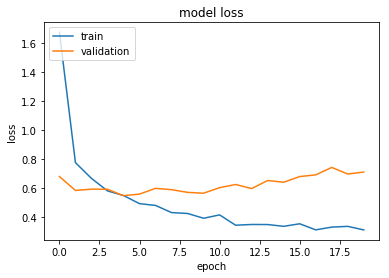

{'1': 86.004784688995215, '2': 84.330143540669852, '3': 80.861244019138752, '4': 82.89473684210526}


In [178]:
# summarize history for loss
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(Xception_results)

Unfortunately, dropout layers and additional dense layers all gave worse results.

I'll just stick to the default(pooling-output 2 layers) model.

In [ ]:
### TODO: Define your architecture.

In [ ]:
# get the bottleneck features
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
trainset = bottleneck_features['train']
validset = bottleneck_features['valid']
testset = bottleneck_features['test']

my_model = Sequential()
my_model.add(GlobalAveragePooling2D(input_shape=trainset.shape[1:]))
my_model.add(Dense(133, activation='softmax'))

my_model.summary()

### (IMPLEMENTATION) Compile the Model

In [ ]:
### TODO: Compile the model.

In [ ]:
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
### TODO: Train the model.

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

my_model.fit(trainset, train_targets, 
             validation_data=(validset, valid_targets),
             epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.

In [ ]:
my_model.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.

In [ ]:
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in testset]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

In [ ]:
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = my_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

In [ ]:
def dog_app(imgpath):
    
    # convert img to option_model's form
    data = cv2.resize(cv2.imread(imgpath), (64,64)).reshape(-1,64,64,3)
    
    # print image
    
    img = cv2.imread(imgpath)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # display the image
    plt.imshow(cv_rgb)    
    
    # if a dog's detected
    if dog_detector(imgpath):
        print("Detected a dog!")
        return Xception_predict_breed(imgpath)
    # else if a human's detected
    elif option_model.predict(data):
        print("Detected a human!")
        print("You look like a ...")
        return Xception_predict_breed(imgpath)
    else:
        print("Error: neither a human nor a dog detected.")
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [ ]:
imgpath = 'images/test1.jpg'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test2.jpg'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test3.jpg'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test4.jpg'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test5.png'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test6.jpg'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test7.jpg'

dog_app(imgpath)

In [ ]:
imgpath = 'images/test8.jpg'

dog_app(imgpath)

### possible points of improvement

the model did worse than i expected. =( I'm disappointed that Steve Jobs was not detected as a human.


1. Steve Jobs is appraently a human but the human detector could not detect correctly.

   => maybe because he had his fingers on his chin. training on more images as such might help.
   
2. I don't know of the dog breeds very much. 'Giant_schnauzer' does not mean much to me.

   => showing a sample image of the dog breed predicted may give better user experience.
   
3. As I suspected.. the model does not recognize side-face images as humans.

   => training on more images as such might help.